# Maritime Trade: MLP Train 2019 Train 2020

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
# Install and import packages
!pip install --upgrade pip
!pip install category_encoders
!pip install tensorflow
!pip install keras-tuner
import os
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import keras_tuner
from keras_tuner import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
my_dpi = 96
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 96.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 22.9 MB/s eta 0:00:00
TensorFlow version: 2.9.1
Eager execution is: True
Keras version: 2.9.0
Num GPUs Available:  1


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Thu Dec  8 14:27:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    D

In [ ]:
# Reproducibility in TF and Pytorch
def init_seeds(seed=1920):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=1920)

In [ ]:
%cd /datasets/maritime_trade1920

/datasets/maritime_trade1920


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633772, 20)


In [ ]:
# Create year-week for stratification
df['DateTime']= pd.to_datetime(df['DateTime'])
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

df = df.drop(['DateTime'], axis=1)

In [ ]:
# Filter df to 2019
df1 = df[df['Year'] == 2019]

# Filter df to 2020
df2 = df[df['Year'] == 2020]

# Drop year variable
df1 = df1.drop(['Year'], axis=1)
df2 = df2.drop(['Year'], axis=1)

del df

In [ ]:
# Prepare 2019 for partitioning data
X = df1.drop(['Metric_Tons'],axis=1)
y = df1['Metric_Tons']

In [ ]:
# Set up train/test split with stratified by 'DateTime_YearWeek'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.DateTime_YearWeek,
                                                    random_state=1920)

In [ ]:
# Drop time variable
X_train = X_train.drop(['DateTime_YearWeek'], axis=1)
X_test = X_test.drop(['DateTime_YearWeek'], axis=1)

In [ ]:
# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print('Dimensions of X_train for input:', X_train.shape[1])

Dimensions of X_train for input: 34


In [ ]:
# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

# Hyperparameter Optimization: 20 Trials with 1 Epoch

In [ ]:
%cd /notebooks/MaritimeTrade/Models/DL/MLP/Models

/notebooks/MaritimeTrade/Models/DL/MLP/Models


In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

# Train 2019

## 2019 HPO3: Batch Size=16, Layers: 4 - 10, Layer Size: 20 - 70

In [ ]:
# Set up callbacks
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

In [ ]:
# Define model for HPO
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 4, 10)):
        model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                     min_value=20, max_value=70,
                                                     step=5),
                                        activation='relu',
                                        kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_19_HPO3sc',
    project_name='MLP_19_HPO3'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=16,
             callbacks=callbacks)

Trial 20 Complete [00h 05m 59s]
val_loss: 9.149958610534668

Best val_loss So Far: 8.78332805633545
Total elapsed time: 02h 01m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=2)

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_19_HPO3sc/MLP_19_HPO3
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 4
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 70
learning_rate: 0.001
layer_size4: 70
layer_size5: 55
layer_size6: 70
layer_size7: 70
layer_size8: 70
layer_size9: 70
Score: 8.78332805633545
Trial summary
Hyperparameters:
num_layers: 4
layer_size0: 70
layer_size1: 65
layer_size2: 70
layer_size3: 20
learning_rate: 0.001
layer_size4: 70
layer_size5: 70
layer_size6: 70
layer_size7: 70
Score: 8.963759422302246
Trial summary
Hyperparameters:
num_layers: 4
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 20
learning_rate: 0.001
layer_size4: 20
layer_size5: 20
layer_size6: 55
layer_size7: 70
layer_size8: 55
layer_size9: 70
Score: 8.96766471862793
Trial summary
Hyperparameters:
num_layers: 4
layer_size0: 70
layer_size1: 45
layer_size2: 70
layer_size3: 50
learning_rate: 0.001
layer_size4: 20
layer_size5: 70
layer_size6: 70
layer_size7: 70
layer_size8

### Fit best model - Batch Size=32

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train19_b32_sc_epochs30_HPO3batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 70)                4970      
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 71        
                                                                 
Total params: 17,431
Trainable params: 17,431
Non-traina

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
67370/67370 [==============================] - 157s 2ms/step - loss: 9.7954 - mse: 562.1500 - val_loss: 8.9230 - val_mse: 472.9009
Epoch 2/30
67370/67370 [==============================] - 155s 2ms/step - loss: 8.7101 - mse: 441.4602 - val_loss: 8.1464 - val_mse: 393.8015
Epoch 3/30
67370/67370 [==============================] - 155s 2ms/step - loss: 8.3865 - mse: 414.2169 - val_loss: 8.0485 - val_mse: 391.1299
Epoch 4/30
67370/67370 [==============================] - 156s 2ms/step - loss: 8.1894 - mse: 397.6087 - val_loss: 7.9009 - val_mse: 378.4498
Epoch 5/30
67370/67370 [==============================] - 157s 2ms/step - loss: 8.0403 - mse: 386.8266 - val_loss: 7.8773 - val_mse: 373.4080
Epoch 6/30
67370/67370 [==============================] - 156s 2ms/step - loss: 7.9302 - mse: 374.9509 - val_loss: 7.6887 - val_mse: 368.6131
Epoch 7/30
67370/67370 [==============================] - 155s 2ms/step - loss: 7.8311 - mse: 365.0150 - val_loss: 7.5164 - val_mse: 353.1789
Epoch 

In [ ]:
# Save model
model.save('./MLP_batch32_sc_30Epochs_HPO3batch16_train19_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train19_b32_sc_epochs30_HPO3batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch32_30Epochs_HPO3batch16_train19_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

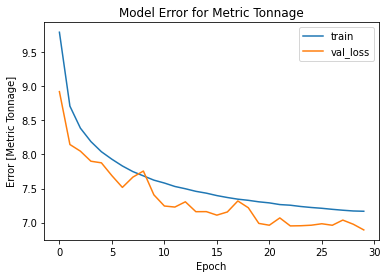

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train19_batch32_sc_30Epochs_HPO3batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

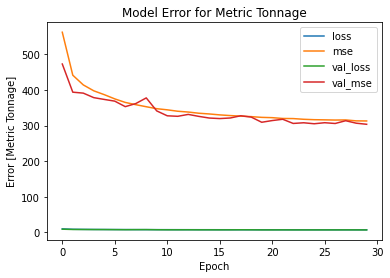

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train19_batch32_sc_30Epochs_HPO3batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

84213/84213 [==============================] - 81s 955us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2694789, 1)

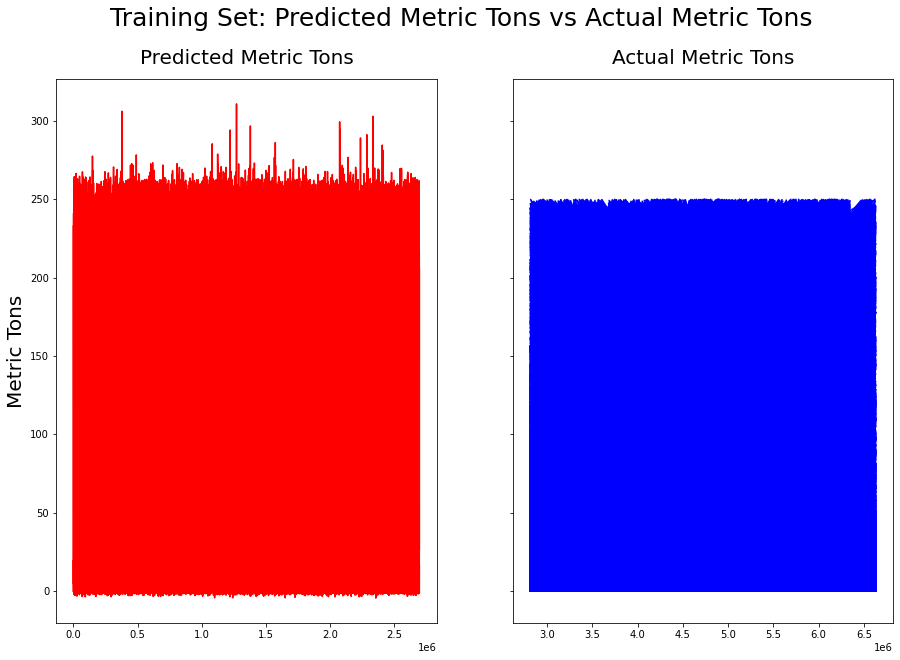

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

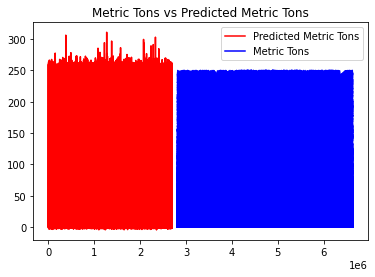

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

21054/21054 [==============================] - 21s 975us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(673698, 1)

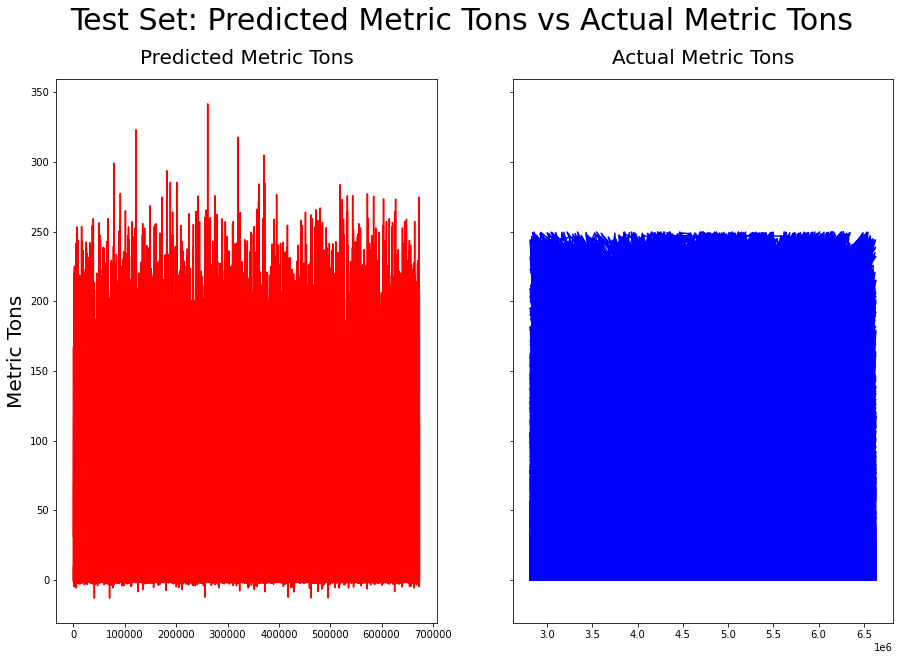

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

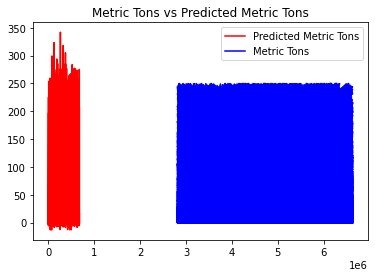

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.821114
MSE: 297.921297
RMSE: 17.260397
R2: 0.703971


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.747238
MSE: 435.549051
RMSE: 20.869812
R2: 0.567549


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 341.8011

Average Metric Tons: 21.895931381717027
Predicted Average Metric Tons: 18.240992

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -13.173259


#### Test on 2020

In [ ]:
# Prepare 2019 for partitioning data
X = df2.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

102041/102041 [==============================] - 101s 983us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3265285, 1)

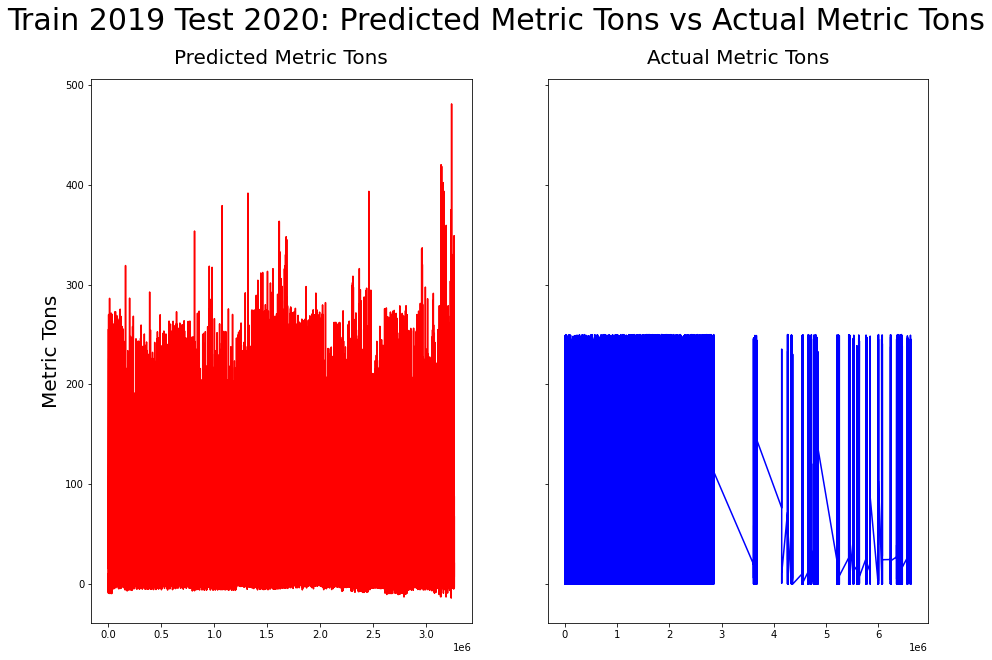

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2019 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19Test20_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

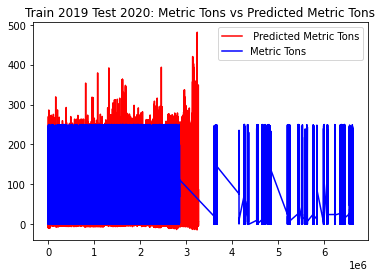

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label=' Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19Test20_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 10.047981
MSE: 524.608402
RMSE: 22.904332
R2: 0.444100


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 481.06577

Average Metric Tons: 21.535245101116747
Predicted Average Metric Tons: 17.65845

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -14.073943


### Fit best model - Batch Size=64

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train19_b64_sc_epochs30_HPO3batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 70)                4970      
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 71        
                                                                 
Total params: 17,431
Trainable params: 17,431
Non-traina

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
33685/33685 [==============================] - 78s 2ms/step - loss: 9.9442 - mse: 569.2576 - val_loss: 9.0136 - val_mse: 480.1576
Epoch 2/30
33685/33685 [==============================] - 77s 2ms/step - loss: 8.7660 - mse: 442.9336 - val_loss: 8.3352 - val_mse: 414.6778
Epoch 3/30
33685/33685 [==============================] - 78s 2ms/step - loss: 8.3844 - mse: 410.0845 - val_loss: 8.1119 - val_mse: 388.4337
Epoch 4/30
33685/33685 [==============================] - 79s 2ms/step - loss: 8.1757 - mse: 393.7235 - val_loss: 7.7568 - val_mse: 370.2344
Epoch 5/30
33685/33685 [==============================] - 79s 2ms/step - loss: 8.0396 - mse: 384.5310 - val_loss: 7.7140 - val_mse: 363.8134
Epoch 6/30
33685/33685 [==============================] - 80s 2ms/step - loss: 7.9279 - mse: 372.4046 - val_loss: 7.7124 - val_mse: 366.8217
Epoch 7/30
33685/33685 [==============================] - 79s 2ms/step - loss: 7.8369 - mse: 364.9145 - val_loss: 7.5521 - val_mse: 350.5675
Epoch 8/30
33

In [ ]:
# Save model
model.save('./MLP_batch64_sc_30Epochs_HPO3batch16_train19_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train19_b64_sc_epochs30_HPO3batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch64_30Epochs_HPO3batch16_train19_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

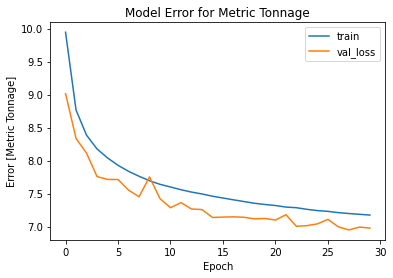

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train19_batch64_sc_30Epochs_HPO3batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

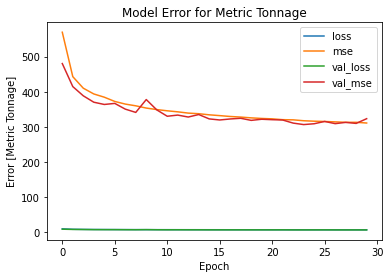

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train19_batch64_sc_30Epochs_HPO3batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

84213/84213 [==============================] - 82s 967us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2694789, 1)

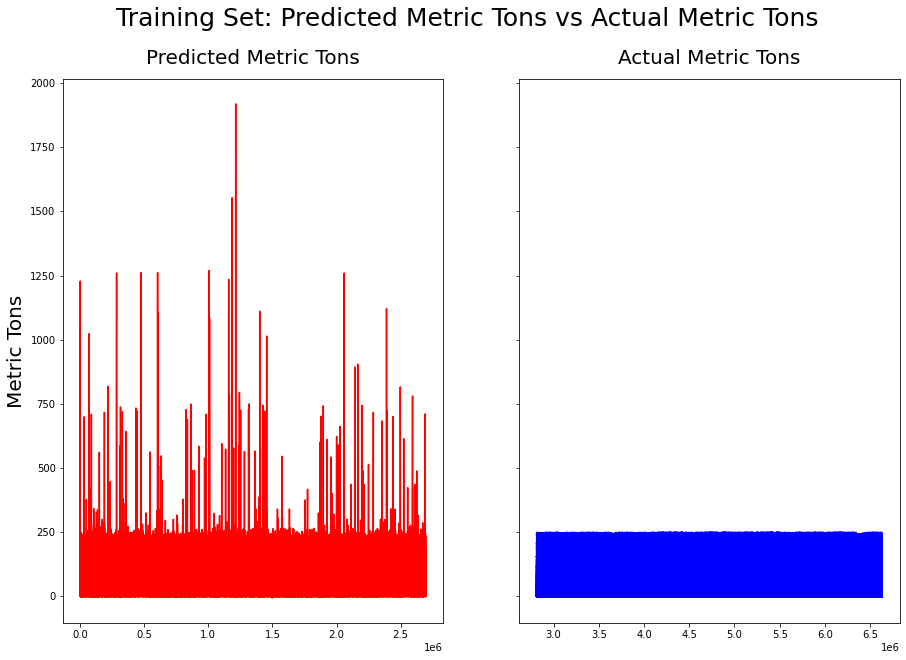

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

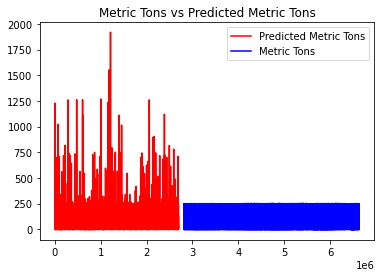

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

21054/21054 [==============================] - 21s 969us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(673698, 1)

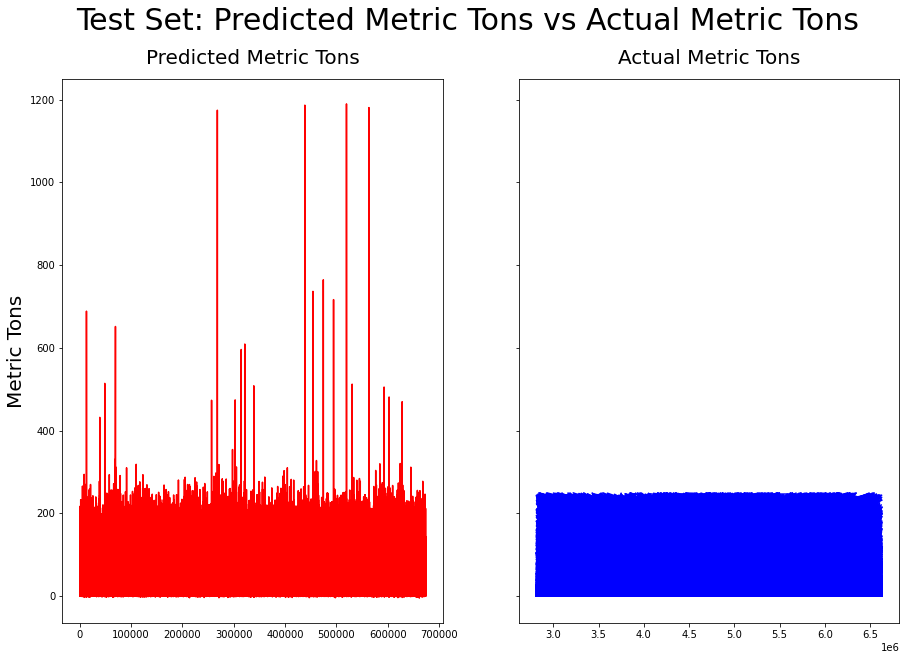

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

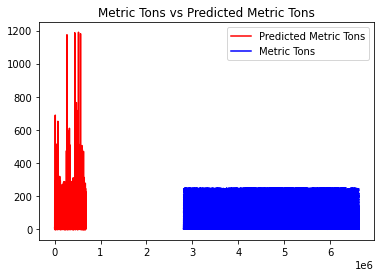

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.898163
MSE: 319.060315
RMSE: 17.862260
R2: 0.682966


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.715604
MSE: 448.981798
RMSE: 21.189191
R2: 0.554212


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 1189.4923

Average Metric Tons: 21.895931381717027
Predicted Average Metric Tons: 19.047865

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -4.579451


#### Test on 2020

In [ ]:
# Prepare 2019 for partitioning data
X = df2.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

102041/102041 [==============================] - 99s 970us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3265285, 1)

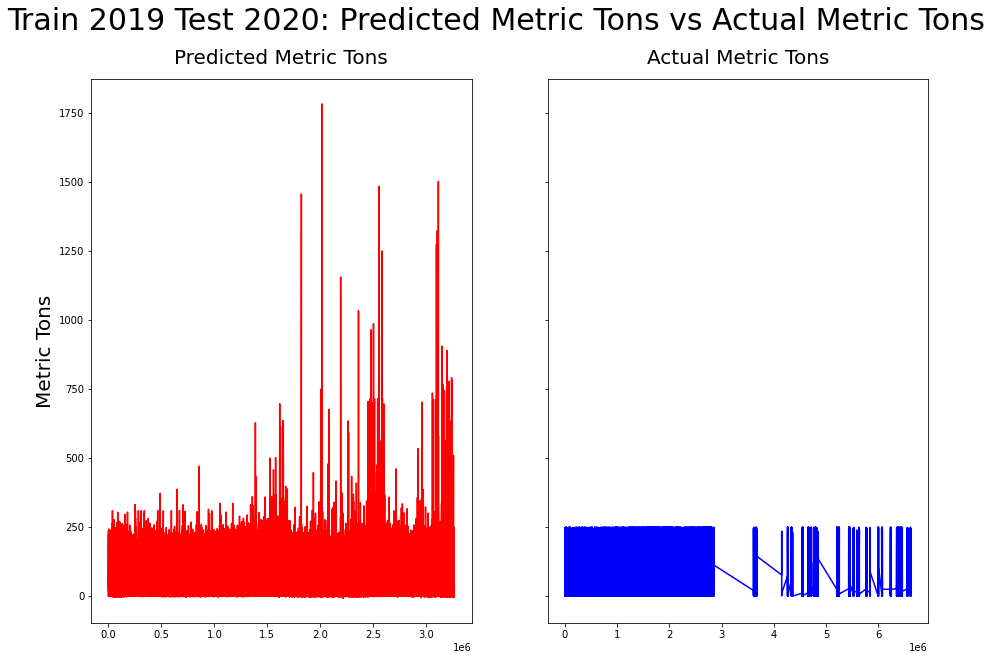

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2019 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19Test20_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

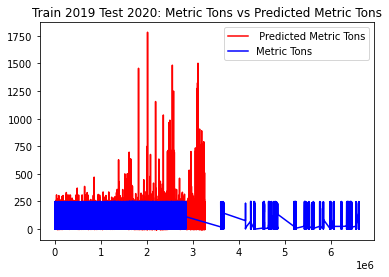

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label=' Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19Test20_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.832118
MSE: 525.252356
RMSE: 22.918385
R2: 0.443418


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 1783.0089

Average Metric Tons: 21.535245101116747
Predicted Average Metric Tons: 18.671064

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -7.4733834


### Fit best model - Batch Size=16

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train19_b16_sc_epochs30_HPO3batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 70)                4970      
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 71        
                                                                 
Total params: 17,431
Trainable params: 17,431
Non-traina

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
134740/134740 [==============================] - 304s 2ms/step - loss: 9.8245 - mse: 575.3618 - val_loss: 8.9796 - val_mse: 482.3776
Epoch 2/30
134740/134740 [==============================] - 297s 2ms/step - loss: 8.7776 - mse: 444.1327 - val_loss: 8.4209 - val_mse: 410.0467
Epoch 3/30
134740/134740 [==============================] - 301s 2ms/step - loss: 8.4345 - mse: 414.0439 - val_loss: 8.0966 - val_mse: 389.1771
Epoch 4/30
134740/134740 [==============================] - 302s 2ms/step - loss: 8.2433 - mse: 397.7776 - val_loss: 8.1210 - val_mse: 402.4286
Epoch 5/30
134740/134740 [==============================] - 303s 2ms/step - loss: 8.1209 - mse: 387.0599 - val_loss: 8.1587 - val_mse: 397.4412
Epoch 6/30
134740/134740 [==============================] - 306s 2ms/step - loss: 8.0251 - mse: 379.0300 - val_loss: 7.7586 - val_mse: 360.2394
Epoch 7/30
134740/134740 [==============================] - 308s 2ms/step - loss: 7.9411 - mse: 374.5984 - val_loss: 7.7140 - val_mse: 3

In [ ]:
# Save model
model.save('./MLP_batch16_sc_30Epochs_HPO3batch16_train19_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train19_b16_sc_epochs30_HPO3batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch16_30Epochs_HPO3batch16_train19_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

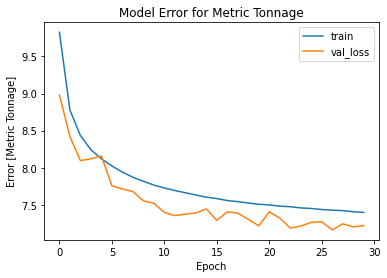

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train19_batch16_sc_30Epochs_HPO3batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

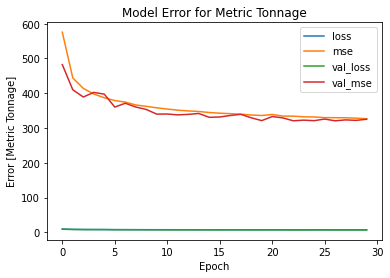

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train19_batch16_sc_30Epochs_HPO3batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

84213/84213 [==============================] - 82s 973us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2694789, 1)

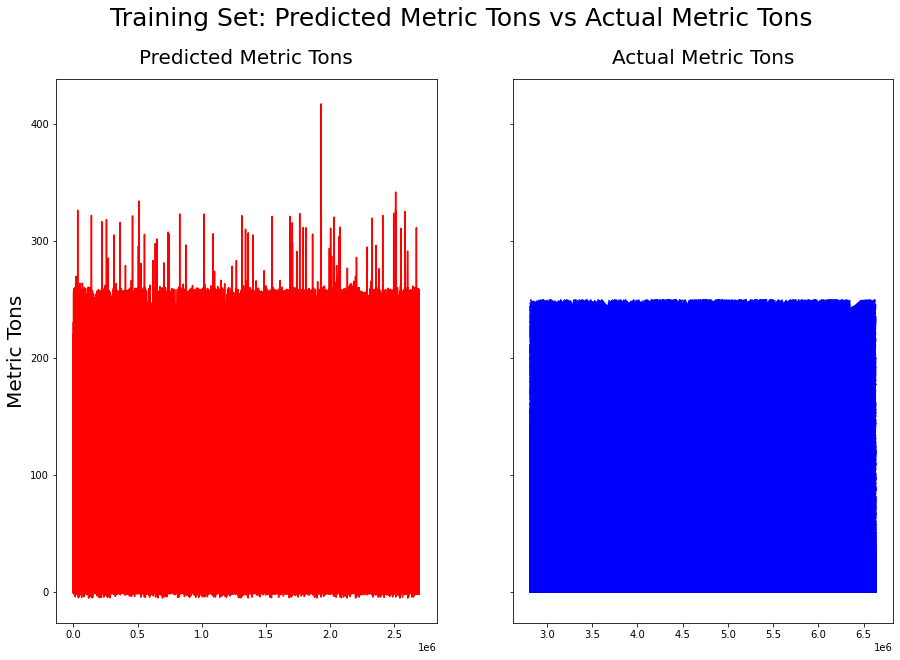

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch16_sc_30Epochs_HPO3batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

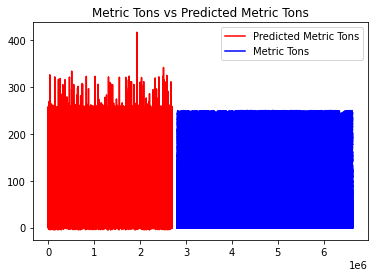

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch16_sc_30Epochs_HPO3batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

21054/21054 [==============================] - 20s 942us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(673698, 1)

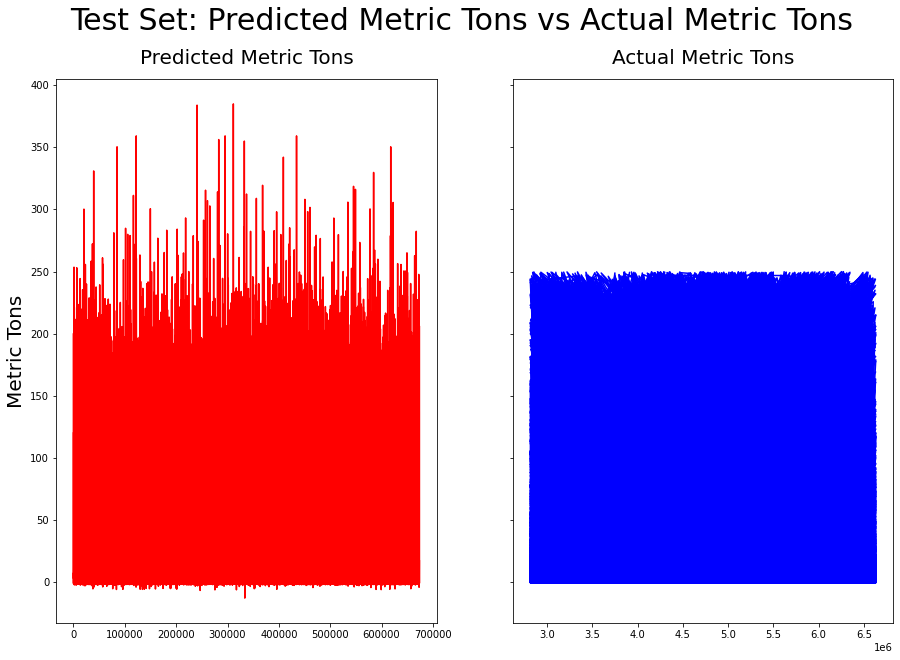

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch16_sc_30Epochs_HPO3batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

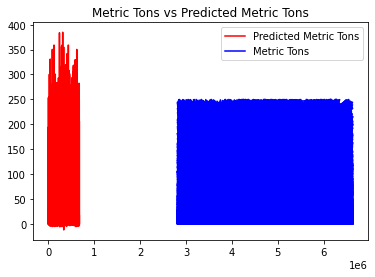

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch16_sc_30Epochs_HPO3batch16_PredictedActual_Test_Overlaid.png',
               dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 7.162949
MSE: 319.604089
RMSE: 17.877474
R2: 0.682426


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 9.382823
MSE: 494.755295
RMSE: 22.243095
R2: 0.508764


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 384.8641

Average Metric Tons: 21.895931381717027
Predicted Average Metric Tons: 17.796833

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -12.539465


#### Test on 2020

In [ ]:
# Prepare 2019 for partitioning data
X = df2.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

102041/102041 [==============================] - 99s 963us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3265285, 1)

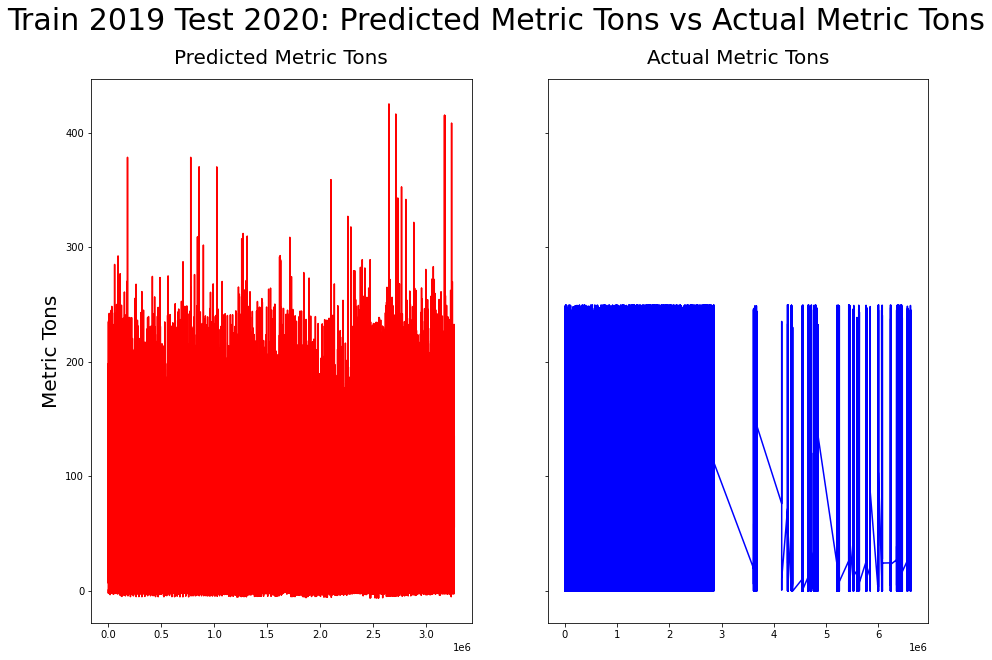

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2019 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19Test20_batch16_sc_30Epochs_HPO3batch16_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

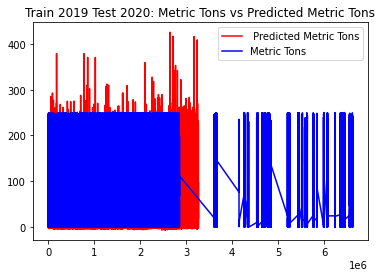

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label=' Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19Test20_batch16_sc_30Epochs_HPO3batch16_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 10.323961
MSE: 564.332764
RMSE: 23.755689
R2: 0.402007


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 425.35257

Average Metric Tons: 21.535245101116747
Predicted Average Metric Tons: 16.922989

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -6.2002134


## 2019 HPO5: Batch=16, Layers: 7 - 13, Layer Size: 40 - 70

In [ ]:
# Set up callbacks
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

In [ ]:
# Define model for HPO
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 7, 13)):
        model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                     min_value=40, max_value=70,
                                                     step=5),
                                        activation='relu',
                                        kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_19_HPO5sc',
    project_name='MLP_19_HPO5'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 7, 'max_value': 13, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size4 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size5 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size6 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
learning_rate (C

In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=16,
             callbacks=callbacks)

Trial 20 Complete [00h 06m 05s]
val_loss: 9.374589920043945

Best val_loss So Far: 9.308611869812012
Total elapsed time: 02h 14m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=2)

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_19_HPO5sc/MLP_19_HPO5
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 7
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 70
layer_size4: 40
layer_size5: 40
layer_size6: 70
learning_rate: 0.0001
layer_size7: 70
layer_size8: 70
layer_size9: 70
layer_size10: 70
layer_size11: 40
layer_size12: 70
Score: 9.308611869812012
Trial summary
Hyperparameters:
num_layers: 7
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 40
layer_size4: 40
layer_size5: 40
layer_size6: 70
learning_rate: 0.0001
layer_size7: 70
layer_size8: 40
layer_size9: 70
layer_size10: 45
layer_size11: 40
layer_size12: 70
Score: 9.325950622558594
Trial summary
Hyperparameters:
num_layers: 7
layer_size0: 65
layer_size1: 70
layer_size2: 70
layer_size3: 50
layer_size4: 40
layer_size5: 40
layer_size6: 70
learning_rate: 0.0001
layer_size7: 40
layer_size8: 60
layer_size9: 70
layer_size10: 70
layer_size11: 70
layer_size12: 70
Score: 9.33407211303711
Trial summary
Hy

### Fit best model - Batch Size=32

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train19_b32_sc_epochs30_HPO5batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 70)                4970      
                                                                 
 dense_4 (Dense)             (None, 40)                2840      
                                                                 
 dense_5 (Dense)             (None, 40)                1640      
                                                                 
 dense_6 (Dense)             (None, 70)                2

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
67370/67370 [==============================] - 171s 3ms/step - loss: 11.2115 - mse: 770.0495 - val_loss: 9.6634 - val_mse: 525.6045
Epoch 2/30
67370/67370 [==============================] - 171s 3ms/step - loss: 9.5180 - mse: 502.1861 - val_loss: 8.9070 - val_mse: 452.0638
Epoch 3/30
67370/67370 [==============================] - 174s 3ms/step - loss: 9.0323 - mse: 459.5558 - val_loss: 8.5535 - val_mse: 425.0791
Epoch 4/30
67370/67370 [==============================] - 177s 3ms/step - loss: 8.7251 - mse: 435.5715 - val_loss: 8.7401 - val_mse: 471.6101
Epoch 5/30
67370/67370 [==============================] - 172s 3ms/step - loss: 8.4848 - mse: 418.9232 - val_loss: 8.1506 - val_mse: 395.2438
Epoch 6/30
67370/67370 [==============================] - 168s 2ms/step - loss: 8.3074 - mse: 407.4936 - val_loss: 8.0401 - val_mse: 402.8894
Epoch 7/30
67370/67370 [==============================] - 170s 3ms/step - loss: 8.1757 - mse: 399.9835 - val_loss: 7.7564 - val_mse: 371.8599
Epoch

In [ ]:
# Save model
model.save('./MLP_batch32_sc_30Epochs_HPO5batch16_train19_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train19_b32_sc_epochs30_HPO5batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch32_30Epochs_HPO5batch16_train19_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

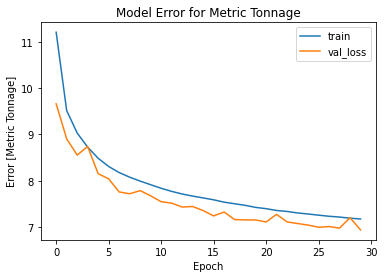

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train19_batch32_sc_30Epochs_HPO5batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

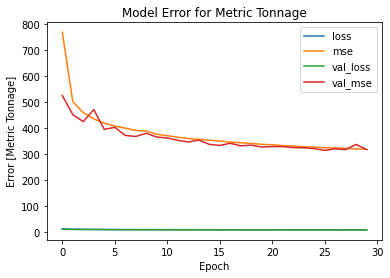

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train19_batch32_sc_30Epochs_HPO5batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

84213/84213 [==============================] - 88s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2694789, 1)

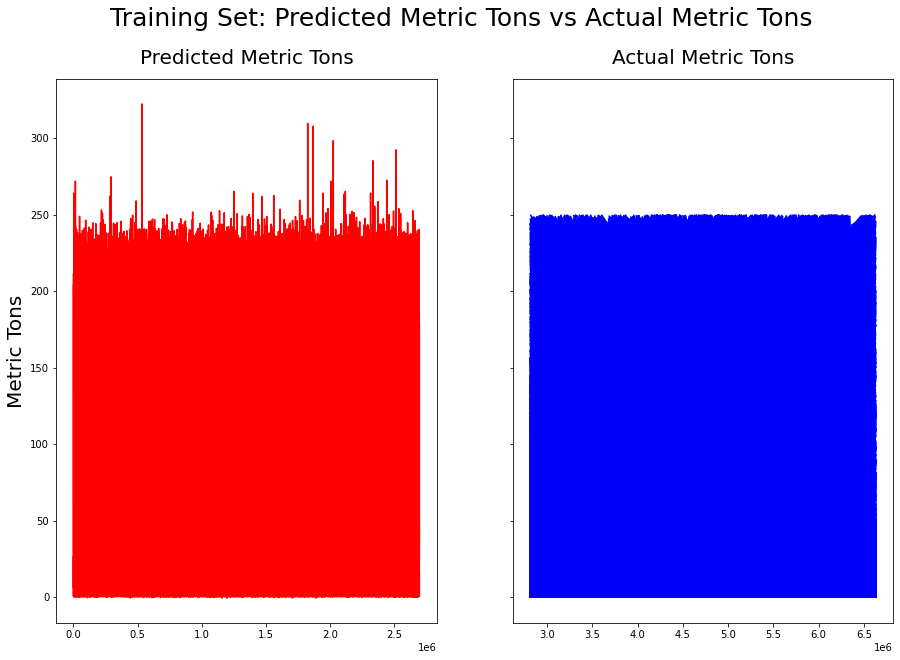

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

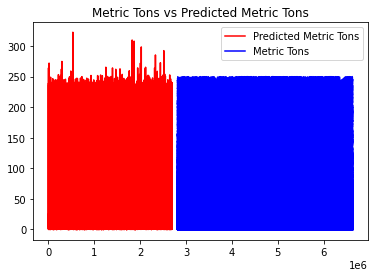

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

21054/21054 [==============================] - 22s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(673698, 1)

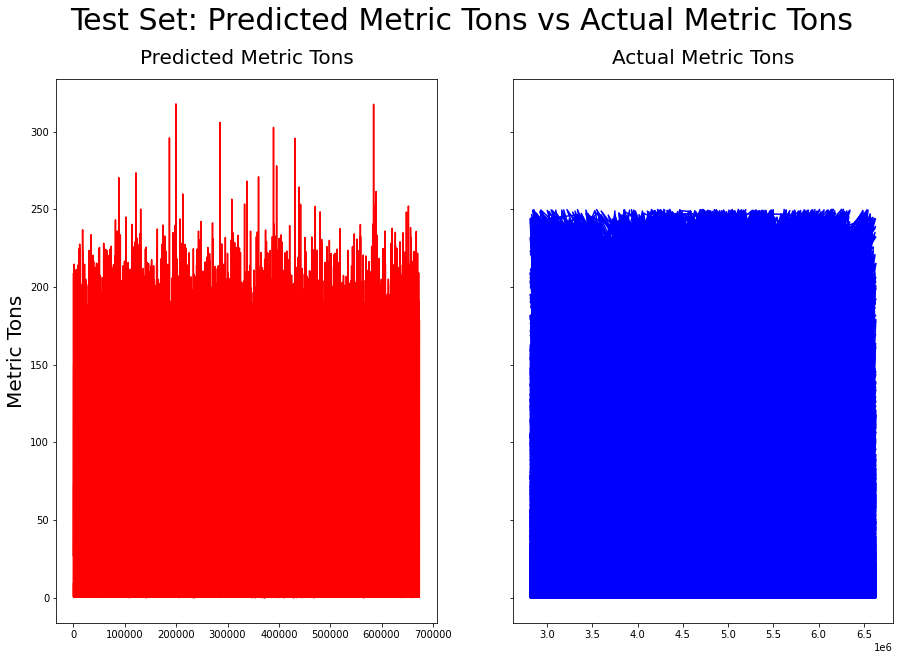

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

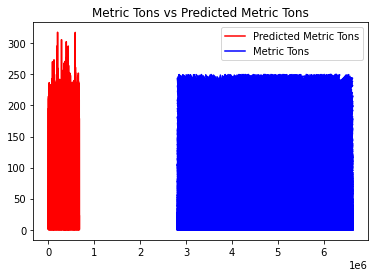

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.861625
MSE: 310.640583
RMSE: 17.624999
R2: 0.691333


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.602806
MSE: 445.864657
RMSE: 21.115508
R2: 0.557307


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 317.8583

Average Metric Tons: 21.895931381717027
Predicted Average Metric Tons: 17.453579

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -0.37032843


#### Test on 2020

In [ ]:
# Prepare 2019 for partitioning data
X = df2.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

102041/102041 [==============================] - 106s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3265285, 1)

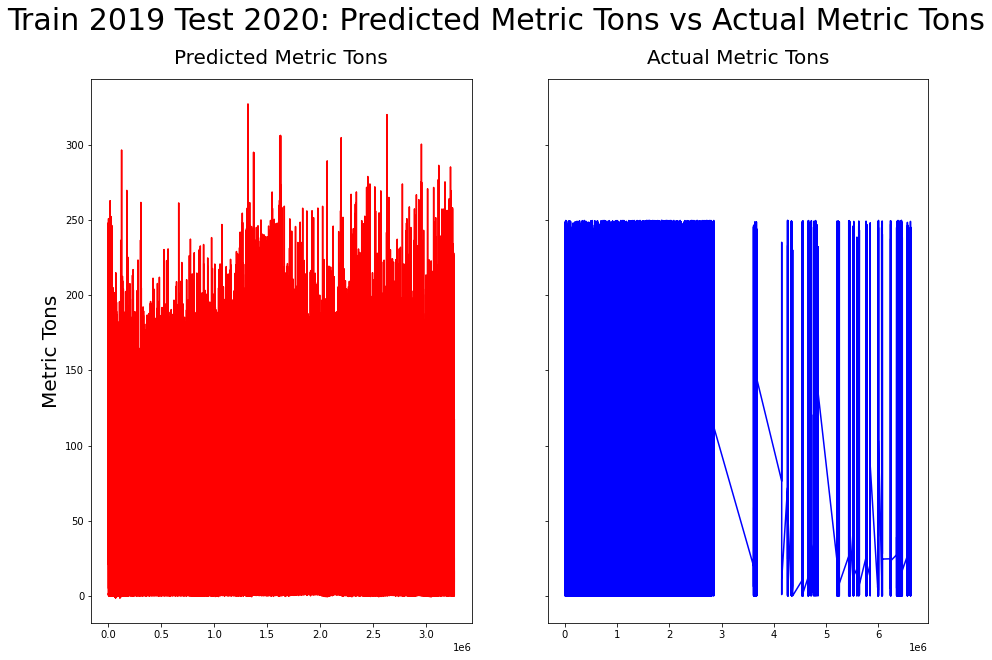

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2019 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19Test20_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

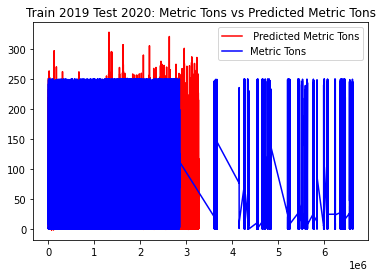

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label=' Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19Test20_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 10.965609
MSE: 606.117418
RMSE: 24.619452
R2: 0.357730


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 327.58246

Average Metric Tons: 21.535245101116747
Predicted Average Metric Tons: 15.6533

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -1.6085


### Fit best model - Batch Size=64

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train19_b64_sc_epochs30_HPO5batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 70)                4970      
                                                                 
 dense_4 (Dense)             (None, 40)                2840      
                                                                 
 dense_5 (Dense)             (None, 40)                1640      
                                                                 
 dense_6 (Dense)             (None, 70)                2

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
33685/33685 [==============================] - 97s 3ms/step - loss: 11.4120 - mse: 747.7125 - val_loss: 9.8307 - val_mse: 544.6473
Epoch 2/30
33685/33685 [==============================] - 97s 3ms/step - loss: 9.7973 - mse: 529.9623 - val_loss: 9.2701 - val_mse: 484.4288
Epoch 3/30
33685/33685 [==============================] - 89s 3ms/step - loss: 9.3332 - mse: 488.5087 - val_loss: 8.8381 - val_mse: 450.8494
Epoch 4/30
33685/33685 [==============================] - 88s 3ms/step - loss: 9.0342 - mse: 460.6596 - val_loss: 8.6550 - val_mse: 448.1874
Epoch 5/30
33685/33685 [==============================] - 88s 3ms/step - loss: 8.8172 - mse: 442.1358 - val_loss: 8.3594 - val_mse: 408.3940
Epoch 6/30
33685/33685 [==============================] - 88s 3ms/step - loss: 8.6457 - mse: 428.9759 - val_loss: 8.3384 - val_mse: 414.1515
Epoch 7/30
33685/33685 [==============================] - 89s 3ms/step - loss: 8.4880 - mse: 417.9034 - val_loss: 8.0267 - val_mse: 399.5196
Epoch 8/30
3

In [ ]:
# Save model
model.save('./MLP_batch64_sc_30Epochs_HPO5batch32_train19_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train19_b64_sc_epochs30_HPO5batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch64_30Epochs_HPO5batch16_train19_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

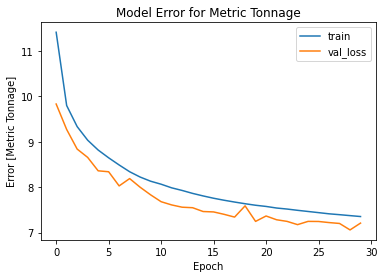

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train19_batch64_sc_30Epochs_HPO5batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

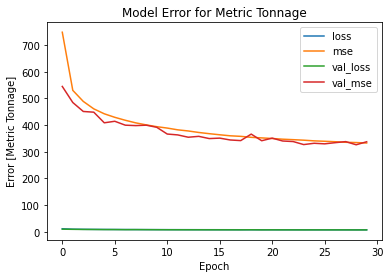

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train19_batch64_sc_30Epochs_HPO5batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

84213/84213 [==============================] - 88s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2694789, 1)

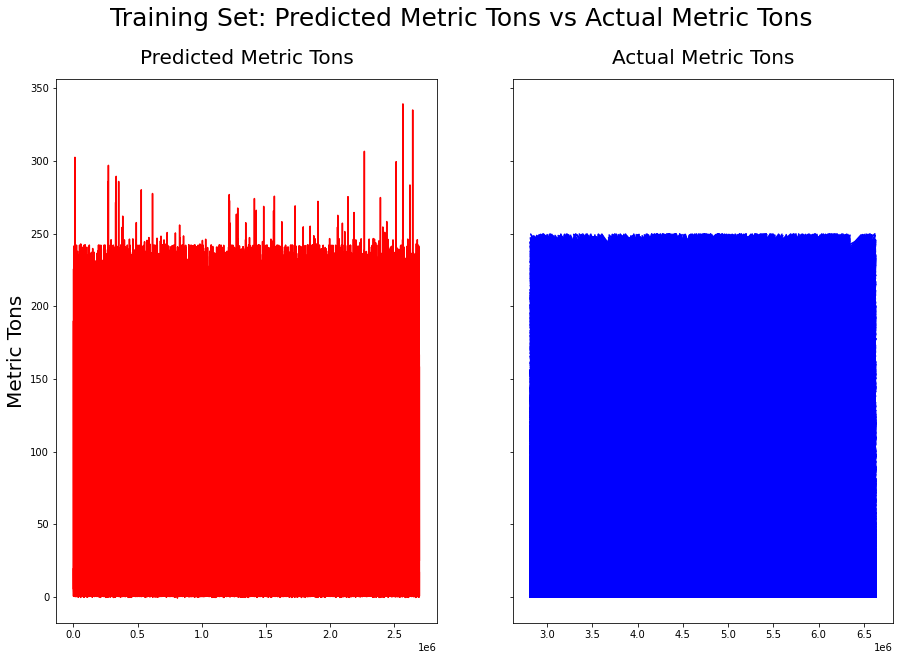

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

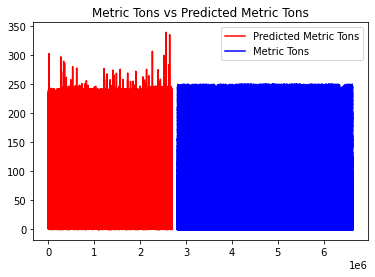

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

21054/21054 [==============================] - 23s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(673698, 1)

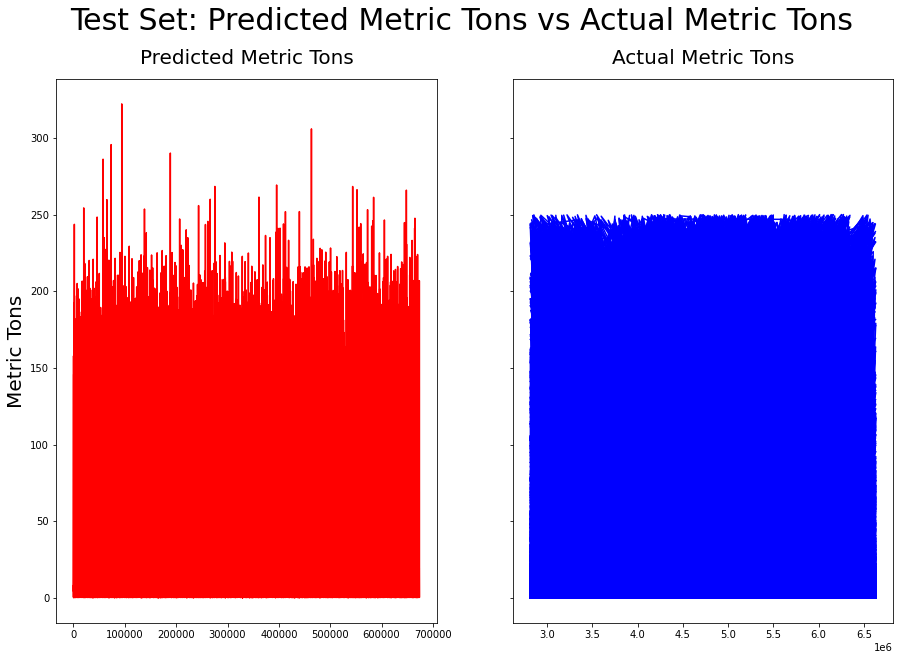

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

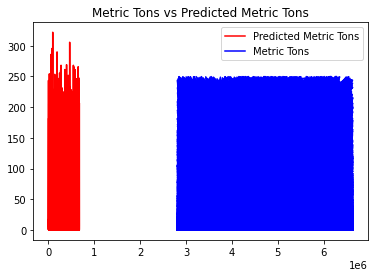

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Test_Overlaid.png',
               dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 7.148838
MSE: 332.172397
RMSE: 18.225597
R2: 0.669938


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 9.356334
MSE: 521.484029
RMSE: 22.836025
R2: 0.482225


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 322.0813

Average Metric Tons: 21.895931381717027
Predicted Average Metric Tons: 17.37625

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: 0.07528019


#### Test on 2020

In [ ]:
# Prepare 2019 for partitioning data
X = df2.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

102041/102041 [==============================] - 106s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3265285, 1)

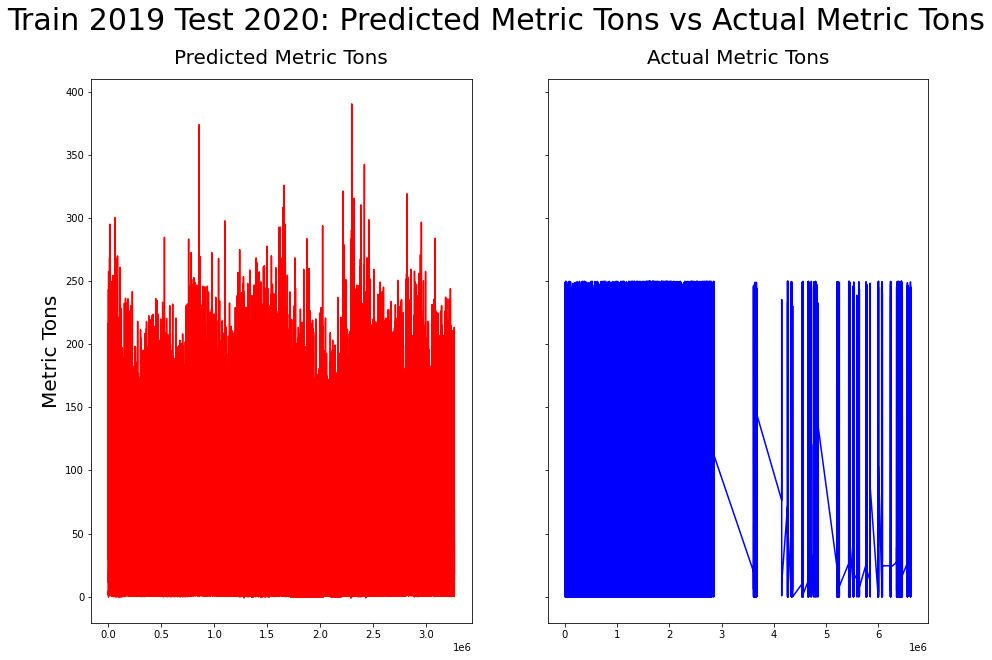

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2019 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train19Test20_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

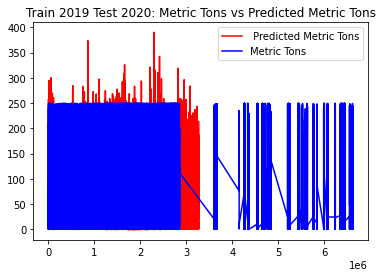

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19Test20_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 11.789098
MSE: 643.893256
RMSE: 25.375052
R2: 0.317701


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 390.38254

Average Metric Tons: 21.535245101116747
Predicted Average Metric Tons: 17.30762

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -1.1227427


# Train 2020

In [ ]:
# Prepare 2019 for partitioning data
X = df2.drop(['Metric_Tons'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Set up train/test split with stratified by 'DateTime_YearWeek'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.DateTime_YearWeek,
                                                    random_state=1920)

In [ ]:
# Drop time variable
X_train = X_train.drop(['DateTime_YearWeek'], axis=1)
X_test = X_test.drop(['DateTime_YearWeek'], axis=1)

In [ ]:
# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print('Dimensions of X_train for input:', X_train.shape[1])

Dimensions of X_train for input: 34


In [ ]:
# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

## 2020 HPO3: Batch Size=16, Layers:4 - 10, Layer Size: 20 - 40

In [ ]:
# Set up callbacks
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

In [ ]:
# Define model for HPO
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 4, 10)):
        model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                     min_value=20, max_value=70,
                                                     step=5),
                                        activation='relu',
                                        kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_20_HPO3_sc',
    project_name='MLP_20_HPO3_sc'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=16,
             callbacks=callbacks)

Trial 20 Complete [00h 04m 57s]
val_loss: 9.287529945373535

Best val_loss So Far: 8.64594554901123
Total elapsed time: 01h 49m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=2)

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_20_HPO3_sc/MLP_20_HPO3_sc
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 4
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 50
learning_rate: 0.001
layer_size4: 20
layer_size5: 70
layer_size6: 70
layer_size7: 70
layer_size8: 70
layer_size9: 70
Score: 8.64594554901123
Trial summary
Hyperparameters:
num_layers: 4
layer_size0: 70
layer_size1: 70
layer_size2: 20
layer_size3: 65
learning_rate: 0.001
layer_size4: 70
layer_size5: 70
layer_size6: 70
layer_size7: 70
layer_size8: 70
layer_size9: 70
Score: 8.816990852355957
Trial summary
Hyperparameters:
num_layers: 4
layer_size0: 70
layer_size1: 65
layer_size2: 70
layer_size3: 20
learning_rate: 0.001
layer_size4: 70
layer_size5: 70
layer_size6: 70
layer_size7: 70
Score: 8.841451644897461
Trial summary
Hyperparameters:
num_layers: 4
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 70
learning_rate: 0.001
layer_size4: 70
layer_size5: 70
layer_size6: 40
layer_size7: 70
layer_

### Fit best model - Batch Size=32

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train20_b32_sc_epochs30_HPO3batch16sc.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  best_model_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 50)                3550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 15,991
Trainable params: 15,991
Non-traina

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
65306/65306 [==============================] - 144s 2ms/step - loss: 9.7496 - mse: 519.9995 - val_loss: 8.8819 - val_mse: 454.1223
Epoch 2/30
65306/65306 [==============================] - 143s 2ms/step - loss: 8.6144 - mse: 417.6983 - val_loss: 8.2656 - val_mse: 409.4539
Epoch 3/30
65306/65306 [==============================] - 141s 2ms/step - loss: 8.2481 - mse: 389.9492 - val_loss: 8.0700 - val_mse: 370.3375
Epoch 4/30
65306/65306 [==============================] - 143s 2ms/step - loss: 8.0486 - mse: 373.7800 - val_loss: 7.6715 - val_mse: 351.1309
Epoch 5/30
65306/65306 [==============================] - 142s 2ms/step - loss: 7.9101 - mse: 361.8810 - val_loss: 7.5350 - val_mse: 337.9046
Epoch 6/30
65306/65306 [==============================] - 143s 2ms/step - loss: 7.7929 - mse: 352.2483 - val_loss: 7.4749 - val_mse: 334.9591
Epoch 7/30
65306/65306 [==============================] - 143s 2ms/step - loss: 7.7069 - mse: 344.7223 - val_loss: 7.4016 - val_mse: 329.2763
Epoch 

In [ ]:
# Save model
model.save('./MLP_batch32_sc_30Epochs_HPO3batch16sc_train20_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train20_b32_sc_epochs30_HPO3batch16sc.h5'
#model = tf.keras.models.load_model('./MLP_batch32_30Epochs_HPO3batch16sc_train20_tf.h5')
# model.load_weights(filepath)

# Show the model architecture
#model.summary()

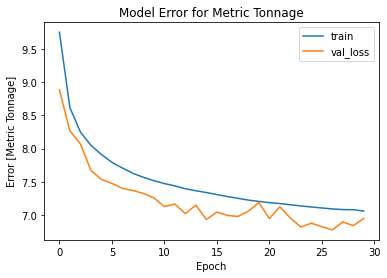

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train20_batch32_sc_30Epochs_HPO3batch16sc_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

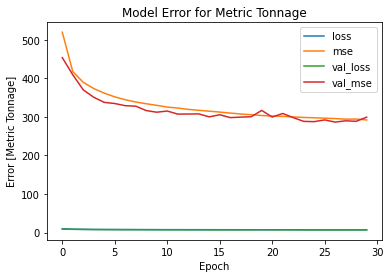

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train20_batch32_sc_30Epochs_HPO3batch16sc_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

81633/81633 [==============================] - 74s 907us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2612228, 1)

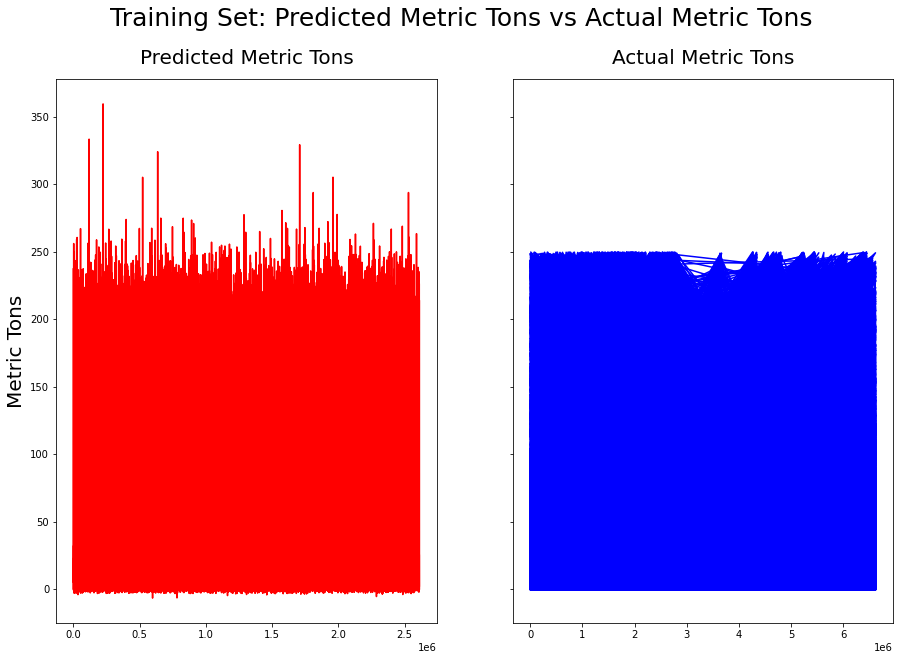

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch32_sc_30Epochs_HPO3batch16sc_PredictedActual_Train_Side.png',
          dpi=my_dpi, bbox_inches='tight')

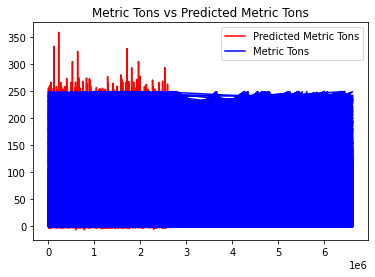

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch32_sc_30Epochs_HPO3batch16sc_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

20409/20409 [==============================] - 18s 895us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(653057, 1)

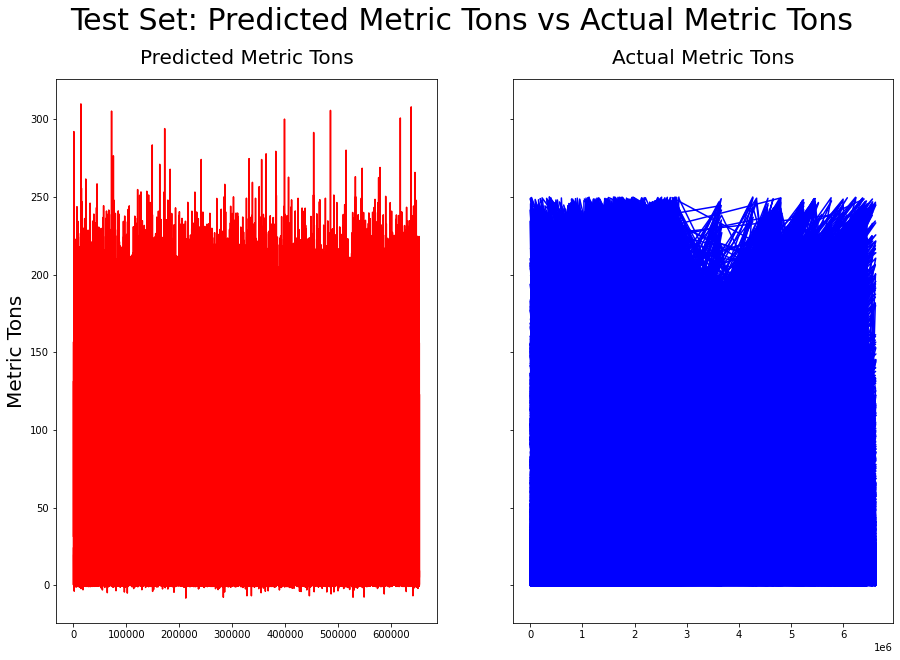

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch32_sc_30Epochs_HPO3batch16sc_PredictedActual_Test_Side.png',
          dpi=my_dpi, bbox_inches='tight')

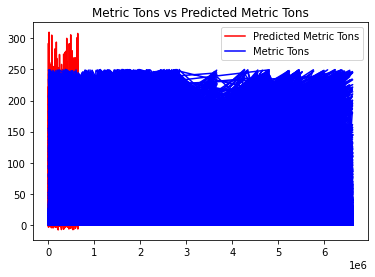

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch32_sc_30Epochs_HPO3batch16sc_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f'% np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.862996
MSE: 290.808157
RMSE: 17.053098
R2: 0.691922


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 7.949197
MSE: 364.425119
RMSE: 19.089922
R2: 0.613459


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons', np.amax(y_test))
print('\nPredicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons', np.average(y_test))
print('Predicted Average Metric Tons', np.average(pred_test))
print('\nMinimum Metric Tons', np.amin(y_test))
print('Predicted Minimum Metric Tons', np.amin(pred_test))

Maximum Metric Tons 249.99

Predicted Max Metric Tons: 309.88245

Average Metric Tons 21.5239324438755
Predicted Average Metric Tons 19.84762

Minimum Metric Tons 0.0
Predicted Minimum Metric Tons -8.149385


#### Test on 2019

In [ ]:
# Prepare 2019 for partitioning data
X = df1.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df1['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

105266/105266 [==============================] - 96s 906us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3368487, 1)

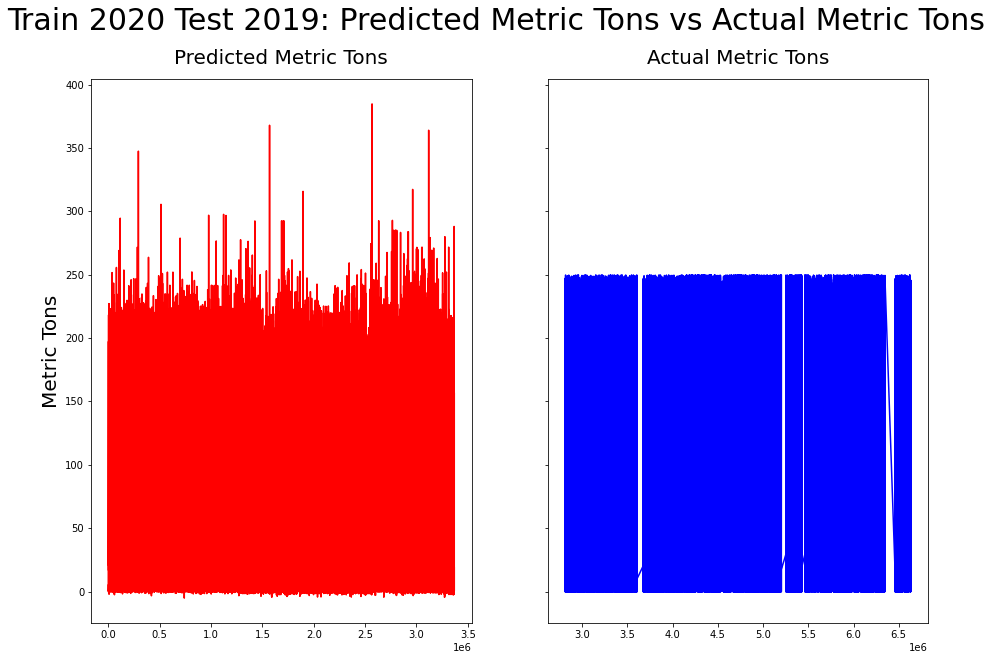

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2020 Test 2019: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20Test19_batch32_sc_30Epochs_HPO3batch16sc_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

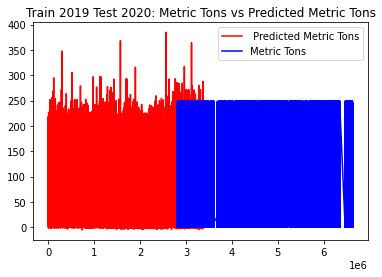

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20Test19_batch32_sc_30Epochs_HPO3batch16sc_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.371814
MSE: 500.704405
RMSE: 22.376425
R2: 0.502552


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 384.80313

Average Metric Tons: 21.897900731099753
Predicted Average Metric Tons: 18.636072

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -5.1350727


### Fit best model - Batch Size=64

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train20_b64_sc_epochs30_HPO3batch16sc.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  best_model_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 50)                3550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 15,991
Trainable params: 15,991
Non-traina

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
32653/32653 [==============================] - 72s 2ms/step - loss: 9.7193 - mse: 520.7775 - val_loss: 8.7076 - val_mse: 418.4297
Epoch 2/30
32653/32653 [==============================] - 72s 2ms/step - loss: 8.6078 - mse: 416.3531 - val_loss: 8.2120 - val_mse: 396.6534
Epoch 3/30
32653/32653 [==============================] - 73s 2ms/step - loss: 8.2661 - mse: 391.8893 - val_loss: 7.9135 - val_mse: 367.8145
Epoch 4/30
32653/32653 [==============================] - 72s 2ms/step - loss: 8.0558 - mse: 374.8338 - val_loss: 7.7132 - val_mse: 356.3395
Epoch 5/30
32653/32653 [==============================] - 73s 2ms/step - loss: 7.8986 - mse: 362.6537 - val_loss: 7.5430 - val_mse: 340.2086
Epoch 6/30
32653/32653 [==============================] - 72s 2ms/step - loss: 7.7744 - mse: 352.3812 - val_loss: 7.4245 - val_mse: 334.8852
Epoch 7/30
32653/32653 [==============================] - 71s 2ms/step - loss: 7.6776 - mse: 344.2169 - val_loss: 7.5704 - val_mse: 346.0816
Epoch 8/30
32

In [ ]:
# Save model
model.save('./MLP_batch64_sc_30Epochs_HPO3batch16sc_train20_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train20_b64_sc_epochs30_HPO3batch16sc.h5'
#model = tf.keras.models.load_model('./MLP_batch64_50Epochs_HPObatch16_train1019_tf.h5')
# model.load_weights(filepath)

# Show the model architecture
#model.summary()

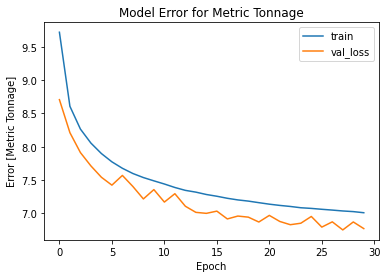

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train20_batch64_sc_30Epochs_HPO3batch16sc_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

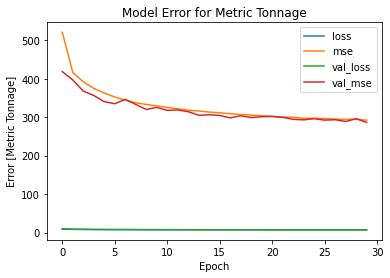

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train20_batch64_sc_30Epochs_HPO3batch16sc_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

81633/81633 [==============================] - 74s 904us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2612228, 1)

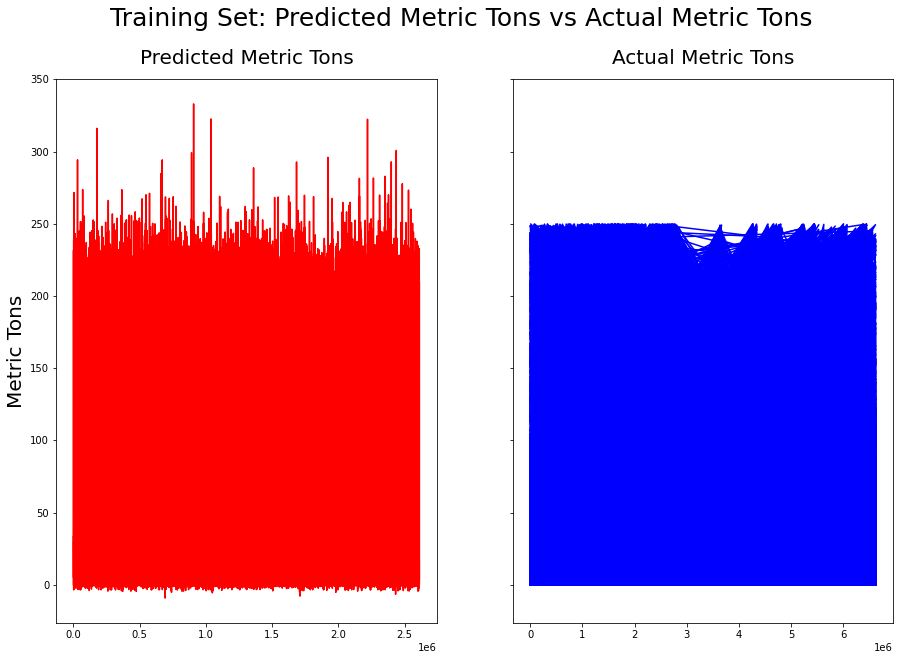

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch64_sc_30Epochs_HPO3batch16sc_PredictedActual_Train_Side.png',
          dpi=my_dpi, bbox_inches='tight')

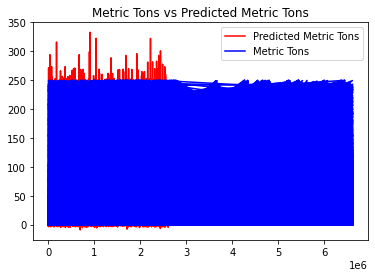

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch64_sc_30Epochs_HPO3batch16sc_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

20409/20409 [==============================] - 19s 904us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(653057, 1)

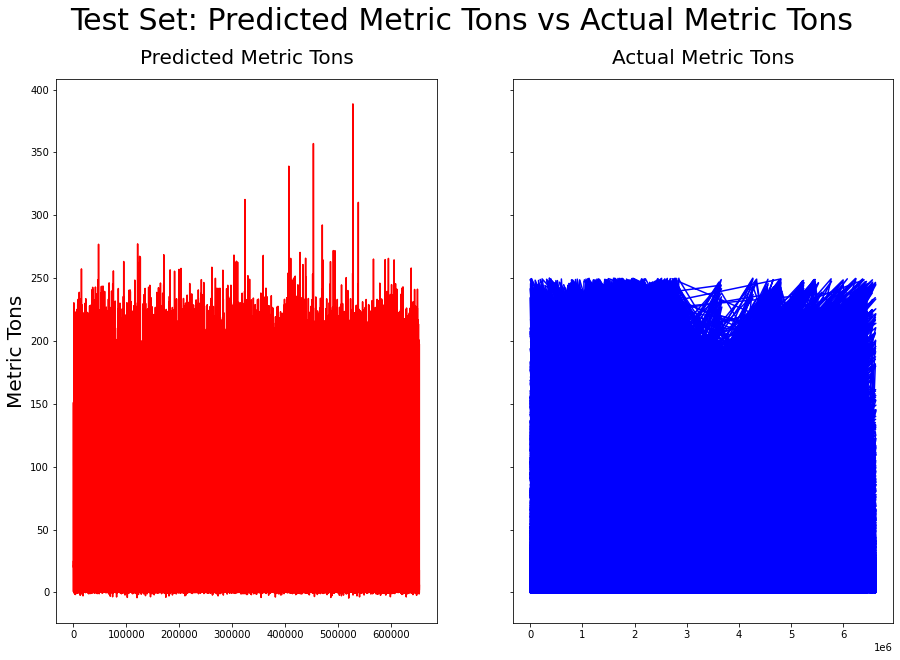

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch64_sc_30Epochs_HPO3batch16sc_PredictedActual_Test_Side.png',
          dpi=my_dpi, bbox_inches='tight')

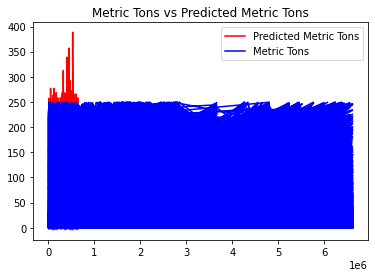

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch64_sc_30Epochs_HPO3batch16sc_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f'% np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.673001
MSE: 276.751381
RMSE: 16.635846
R2: 0.706813


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 7.910120
MSE: 363.629121
RMSE: 19.069062
R2: 0.614303


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons', np.amax(y_test))
print('\nPredicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons', np.average(y_test))
print('Predicted Average Metric Tons', np.average(pred_test))
print('\nMinimum Metric Tons', np.amin(y_test))
print('Predicted Minimum Metric Tons', np.amin(pred_test))

Maximum Metric Tons 249.99
Predicted Max Metric Tons: 388.60556

Average Metric Tons 21.5239324438755
Predicted Average Metric Tons 20.17421

Minimum Metric Tons 0.0
Predicted Minimum Metric Tons -4.4805655


#### Test on 2019

In [ ]:
# Prepare 2019 for partitioning data
X = df1.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df1['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

105266/105266 [==============================] - 96s 904us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3368487, 1)

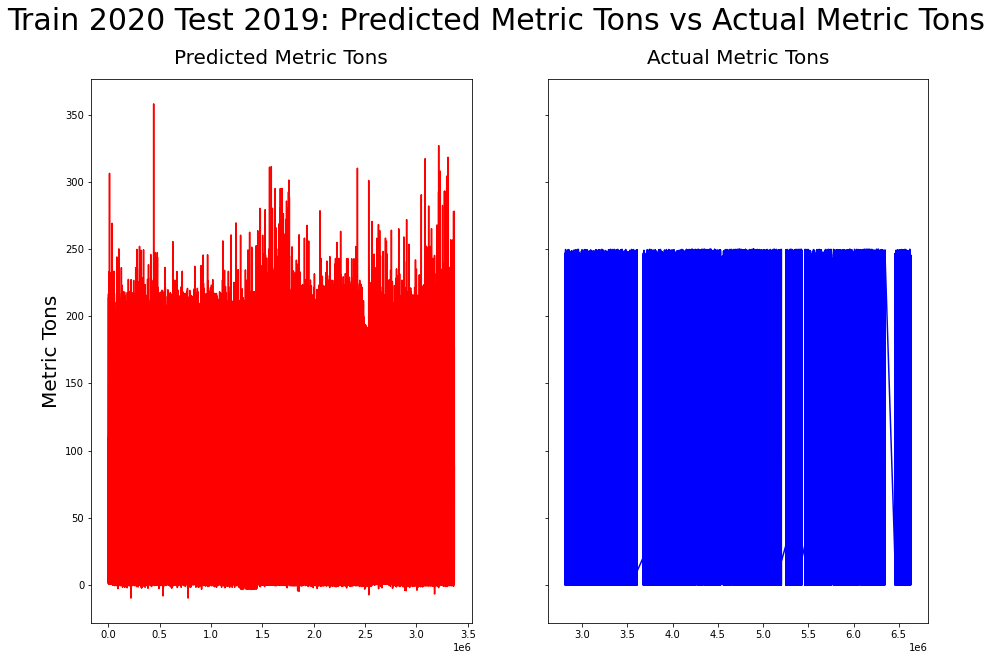

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2020 Test 2019: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20Test19_batch64_sc_30Epochs_HPO3batch16sc_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

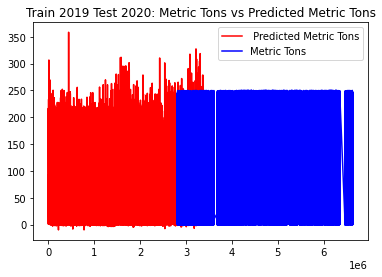

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20Test19_batch64_sc_30Epochs_HPO3batch16sc_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.253007
MSE: 481.708027
RMSE: 21.947848
R2: 0.521425


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 358.23325

Average Metric Tons: 21.897900731099753
Predicted Average Metric Tons: 19.320496

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -9.89946


### Fit best model - Batch Size=16

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train20_b16_sc_epochs30_HPO3batch16sc.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  best_model_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 50)                3550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 15,991
Trainable params: 15,991
Non-traina

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
130612/130612 [==============================] - 286s 2ms/step - loss: 9.6175 - mse: 513.7285 - val_loss: 8.7638 - val_mse: 443.1494
Epoch 2/30
130612/130612 [==============================] - 290s 2ms/step - loss: 8.6341 - mse: 419.8096 - val_loss: 8.2315 - val_mse: 399.7924
Epoch 3/30
130612/130612 [==============================] - 286s 2ms/step - loss: 8.3096 - mse: 390.8534 - val_loss: 8.2955 - val_mse: 385.4254
Epoch 4/30
130612/130612 [==============================] - 288s 2ms/step - loss: 8.1207 - mse: 374.9299 - val_loss: 7.8143 - val_mse: 364.6575
Epoch 5/30
130612/130612 [==============================] - 286s 2ms/step - loss: 7.9887 - mse: 366.5000 - val_loss: 7.6868 - val_mse: 352.1022
Epoch 6/30
130612/130612 [==============================] - 285s 2ms/step - loss: 7.8826 - mse: 356.4500 - val_loss: 7.6232 - val_mse: 341.9635
Epoch 7/30
130612/130612 [==============================] - 285s 2ms/step - loss: 7.8017 - mse: 349.9478 - val_loss: 7.4948 - val_mse: 3

In [ ]:
# Save model
model.save('./MLP_batch16_sc_30Epochs_HPO3batch16sc_train20_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train20_b16_sc_epochs30_HPO3batch16sc.h5'
#model = tf.keras.models.load_model('./MLP_batch64_50Epochs_HPObatch16_train1019_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

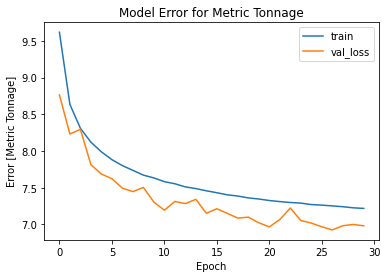

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train20_batch16_sc_30Epochs_HPO3batch16sc_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

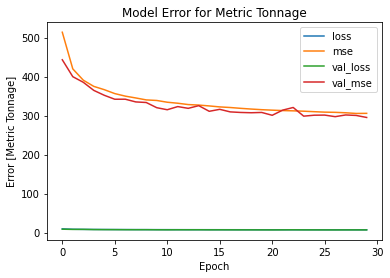

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train20_batch16_sc_30Epochs_HPO3batch16sc_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

81633/81633 [==============================] - 73s 895us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2612228, 1)

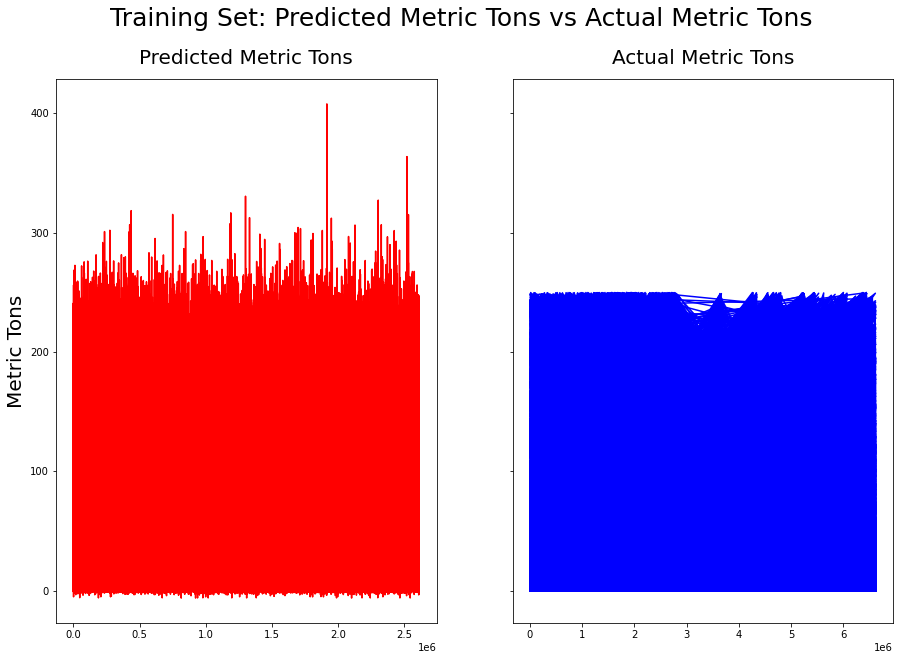

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch16_sc_30Epochs_HPO3batch16sc_PredictedActual_Train_Side.png',
          dpi=my_dpi, bbox_inches='tight')

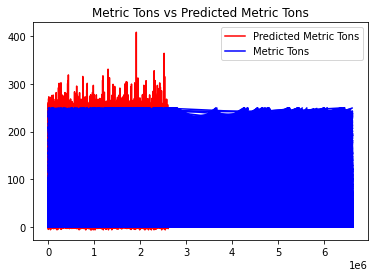

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch16_sc_30Epochs_HPO3batch16sc_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

20409/20409 [==============================] - 19s 925us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(653057, 1)

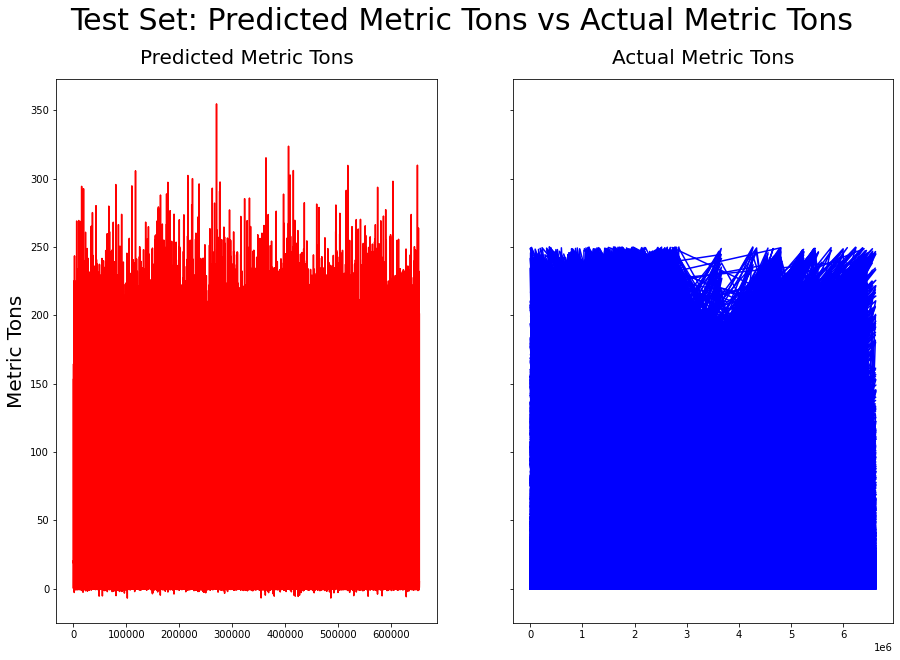

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch16_sc_30Epochs_HPO3batch16sc_PredictedActual_Test_Side.png',
          dpi=my_dpi, bbox_inches='tight')

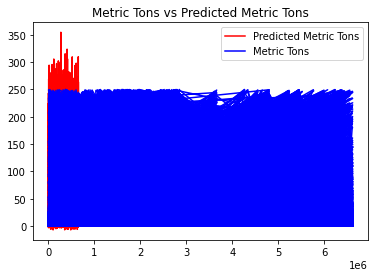

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch16_sc_30Epochs_HPO3batch16sc_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f'% np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.907545
MSE: 288.293302
RMSE: 16.979202
R2: 0.694586


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 7.852433
MSE: 353.001033
RMSE: 18.788322
R2: 0.625576


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons', np.amax(y_test))
print('\nPredicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons', np.average(y_test))
print('Predicted Average Metric Tons', np.average(pred_test))
print('\nMinimum Metric Tons', np.amin(y_test))
print('Predicted Minimum Metric Tons', np.amin(pred_test))

Maximum Metric Tons 249.99
Predicted Max Metric Tons: 354.60147

Average Metric Tons 21.5239324438755
Predicted Average Metric Tons 20.363922

Minimum Metric Tons 0.0
Predicted Minimum Metric Tons -6.8470907


#### Test on 2019

In [ ]:
# Prepare 2019 for partitioning data
X = df1.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df1['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

105266/105266 [==============================] - 98s 929us/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3368487, 1)

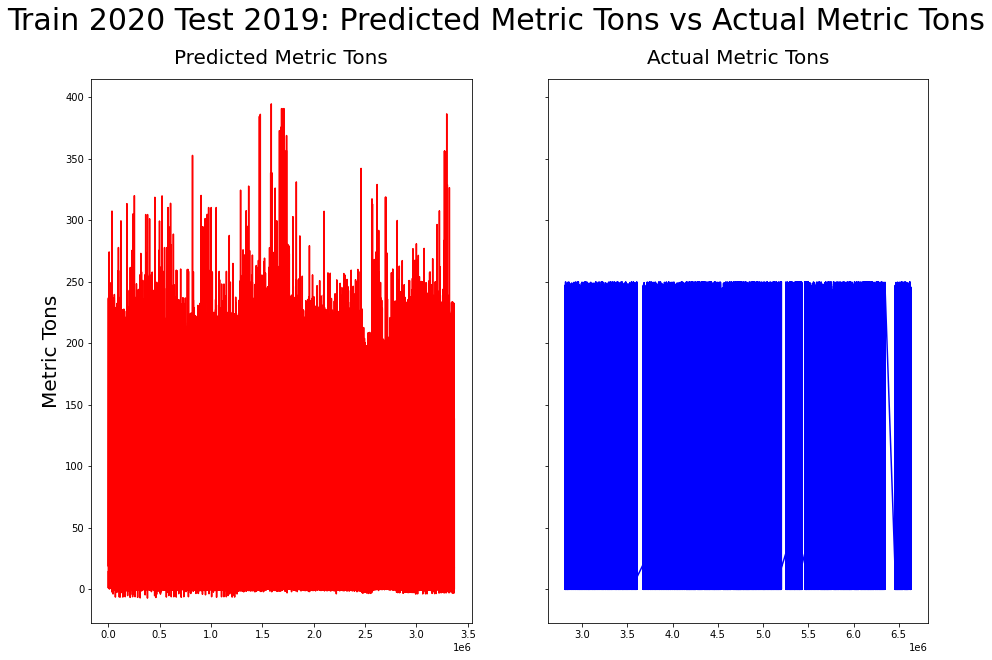

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2020 Test 2019: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20Test19_batch16_sc_30Epochs_HPO3batch16sc_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

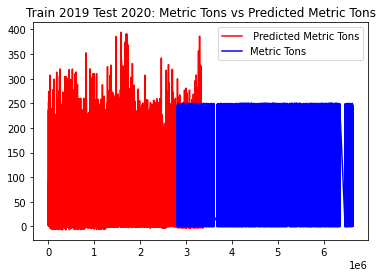

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label=' Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20Test19_batch16_sc_30Epochs_HPO3batch16sc_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.186805
MSE: 482.177014
RMSE: 21.958529
R2: 0.520959


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 394.3671

Average Metric Tons: 21.897900731099753
Predicted Average Metric Tons: 19.089478

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -7.085166


## 2020 HPO5: Batch Size=16, Layers: 7 - 13, Layer Size: 40 - 70

In [ ]:
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

In [ ]:
# Define model for HPO
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 7, 13)):
        model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                     min_value=40, max_value=70,
                                                     step=5),
                                        activation='relu',
                                        kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_20_HPO5sc',
    project_name='MLP_20_HPO5'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 7, 'max_value': 13, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size4 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size5 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size6 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
learning_rate (C

In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=16,
             callbacks=callbacks)

Trial 20 Complete [00h 06m 04s]
val_loss: 9.262261390686035

Best val_loss So Far: 8.955842971801758
Total elapsed time: 02h 19m 46s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=2)

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_20_HPO5sc/MLP_20_HPO5
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 11
layer_size0: 65
layer_size1: 65
layer_size2: 60
layer_size3: 45
layer_size4: 60
layer_size5: 65
layer_size6: 45
learning_rate: 0.001
layer_size7: 65
layer_size8: 65
layer_size9: 50
layer_size10: 45
layer_size11: 50
layer_size12: 40
Score: 8.955842971801758
Trial summary
Hyperparameters:
num_layers: 9
layer_size0: 70
layer_size1: 70
layer_size2: 40
layer_size3: 40
layer_size4: 70
layer_size5: 70
layer_size6: 40
learning_rate: 0.001
layer_size7: 70
layer_size8: 55
layer_size9: 60
layer_size10: 40
layer_size11: 55
layer_size12: 60
Score: 9.026692390441895
Trial summary
Hyperparameters:
num_layers: 13
layer_size0: 70
layer_size1: 70
layer_size2: 45
layer_size3: 40
layer_size4: 70
layer_size5: 70
layer_size6: 50
learning_rate: 0.0001
layer_size7: 60
layer_size8: 70
layer_size9: 70
layer_size10: 40
layer_size11: 65
layer_size12: 50
Score: 9.05501937866211
Trial summary
Hy

### Fit best model - Batch Size=32

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train20_b32_sc_epochs30_HPO5batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))

model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(60, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 40)                2840      
                                                                 
 dense_3 (Dense)             (None, 70)                2870      
                                                                 
 dense_4 (Dense)             (None, 70)                4970      
                                                                 
 dense_5 (Dense)             (None, 40)                2840      
                                                                 
 dense_6 (Dense)             (None, 70)                2

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
65306/65306 [==============================] - 202s 3ms/step - loss: 10.5622 - mse: 616.6284 - val_loss: 9.2018 - val_mse: 480.5653
Epoch 2/30
65306/65306 [==============================] - 197s 3ms/step - loss: 9.1723 - mse: 460.2661 - val_loss: 8.7241 - val_mse: 440.4626
Epoch 3/30
65306/65306 [==============================] - 195s 3ms/step - loss: 8.7572 - mse: 423.4736 - val_loss: 8.4677 - val_mse: 403.9790
Epoch 4/30
65306/65306 [==============================] - 196s 3ms/step - loss: 8.4687 - mse: 400.2460 - val_loss: 7.9495 - val_mse: 373.3796
Epoch 5/30
65306/65306 [==============================] - 197s 3ms/step - loss: 8.2474 - mse: 385.6289 - val_loss: 7.8316 - val_mse: 367.0729
Epoch 6/30
65306/65306 [==============================] - 202s 3ms/step - loss: 8.0691 - mse: 373.2658 - val_loss: 7.8150 - val_mse: 364.5799
Epoch 7/30
65306/65306 [==============================] - 199s 3ms/step - loss: 7.9329 - mse: 364.4851 - val_loss: 7.7372 - val_mse: 365.7344
Epoch

In [ ]:
# Save model
model.save('./MLP_batch32_sc_30Epochs_HPO5batch32_train20_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train20_b32_sc_epochs30_HPO5batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch32_30Epochs_HPO5batch16_train20_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

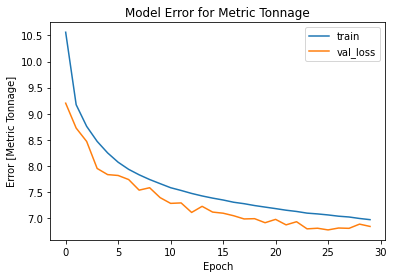

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train20_batch32_sc_30Epochs_HPO45batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

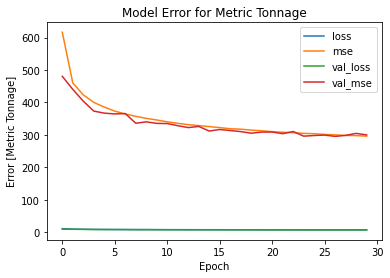

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train19_batch32_sc_30Epochs_HPO5batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

81633/81633 [==============================] - 96s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2612228, 1)

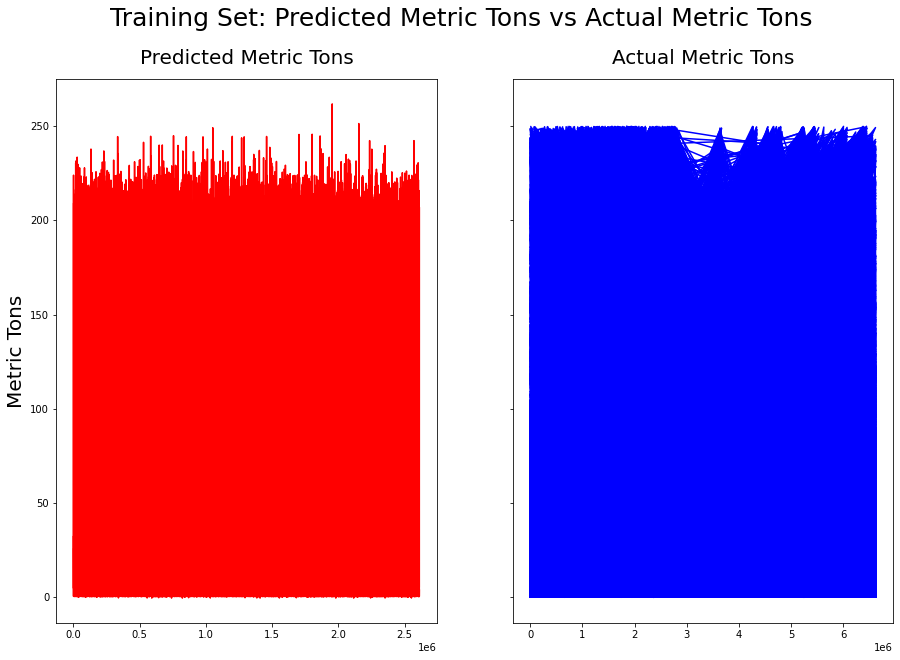

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

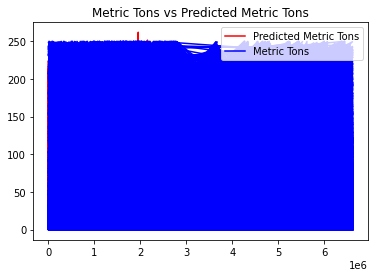

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

20409/20409 [==============================] - 24s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(653057, 1)

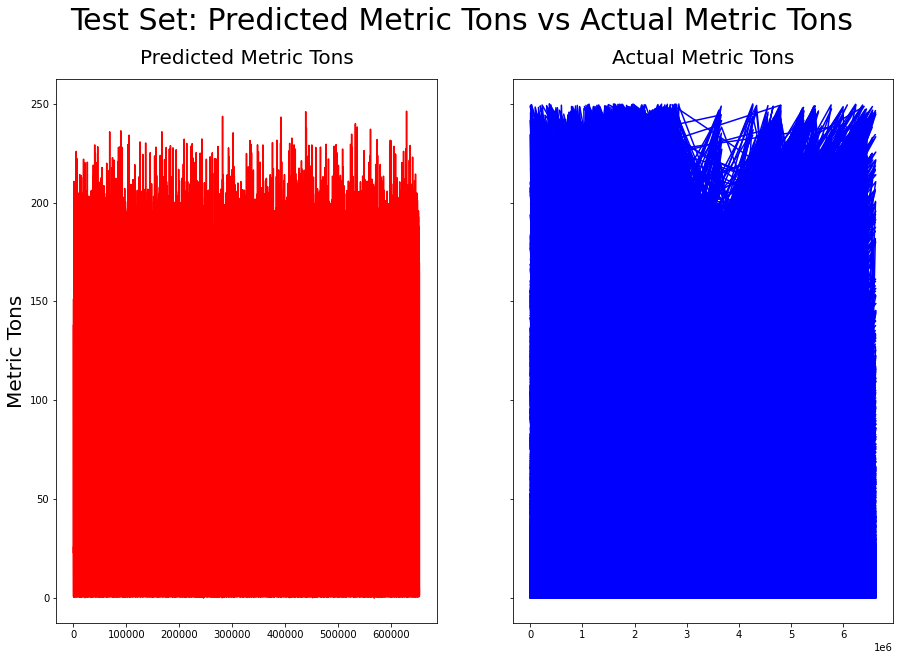

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

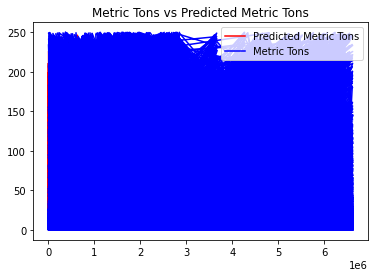

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.743100
MSE: 290.759245
RMSE: 17.051664
R2: 0.691973


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 7.666669
MSE: 351.065706
RMSE: 18.736747
R2: 0.627629


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 246.31972

Average Metric Tons: 21.5239324438755
Predicted Average Metric Tons: 19.69039

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -0.21363783


#### Test on 2019

In [ ]:
# Prepare 2019 for partitioning data
X = df1.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df1['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

105266/105266 [==============================] - 125s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3368487, 1)

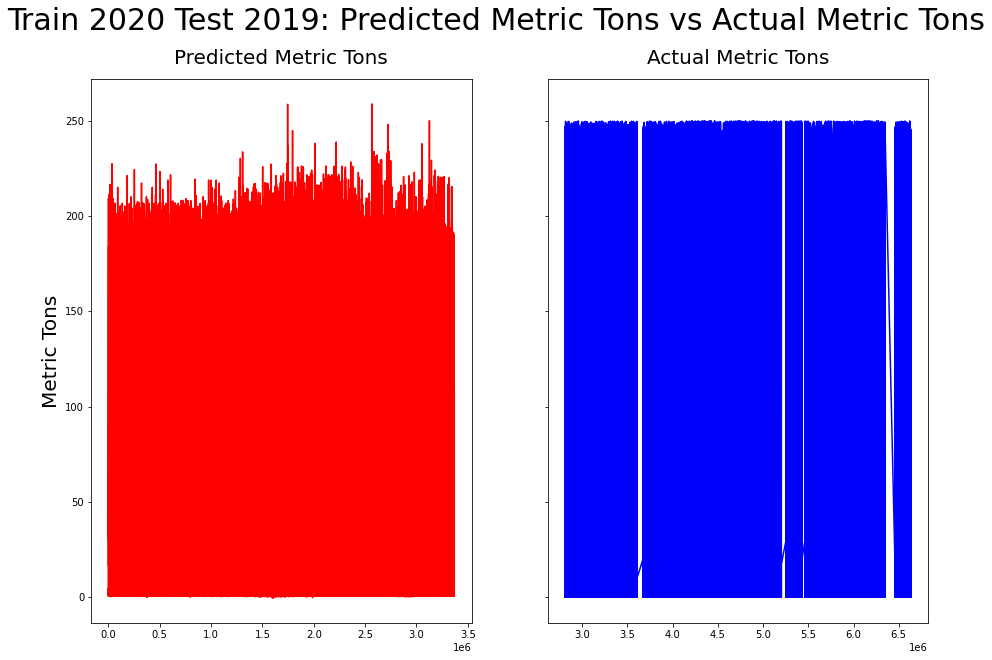

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2020 Test 2019: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20Test19_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

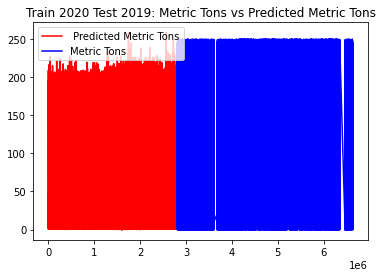

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2020 Test 2019: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20Test19_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.274905
MSE: 501.066718
RMSE: 22.384520
R2: 0.502192


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 258.91766

Average Metric Tons: 21.897900731099753
Predicted Average Metric Tons: 18.422684

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -0.4527645


### Fit best model - Batch Size=64

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train20_b64_sc_epochs30_HPO5batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))

model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(60, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 40)                2840      
                                                                 
 dense_3 (Dense)             (None, 70)                2870      
                                                                 
 dense_4 (Dense)             (None, 70)                4970      
                                                                 
 dense_5 (Dense)             (None, 40)                2840      
                                                                 
 dense_6 (Dense)             (None, 70)                2

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
32653/32653 [==============================] - 106s 3ms/step - loss: 11.0742 - mse: 664.7635 - val_loss: 9.5644 - val_mse: 507.7175
Epoch 2/30
32653/32653 [==============================] - 105s 3ms/step - loss: 9.4938 - mse: 494.7403 - val_loss: 9.0467 - val_mse: 482.3329
Epoch 3/30
32653/32653 [==============================] - 105s 3ms/step - loss: 9.1207 - mse: 460.6794 - val_loss: 8.6224 - val_mse: 425.1812
Epoch 4/30
32653/32653 [==============================] - 105s 3ms/step - loss: 8.8213 - mse: 433.5251 - val_loss: 8.3369 - val_mse: 402.5468
Epoch 5/30
32653/32653 [==============================] - 104s 3ms/step - loss: 8.5821 - mse: 412.7993 - val_loss: 8.1212 - val_mse: 377.5856
Epoch 6/30
32653/32653 [==============================] - 105s 3ms/step - loss: 8.3895 - mse: 398.7610 - val_loss: 7.9873 - val_mse: 378.3203
Epoch 7/30
32653/32653 [==============================] - 104s 3ms/step - loss: 8.2325 - mse: 387.2114 - val_loss: 7.9462 - val_mse: 380.7739
Epoch

In [ ]:
# Save model
model.save('./MLP_batch64_sc_30Epochs_HPO5batch32_train20_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train20_b64_sc_epochs30_HPO5batch16.h5
#model = tf.keras.models.load_model('./MLP_batch32_30Epochs_HPO5batch16_train20_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

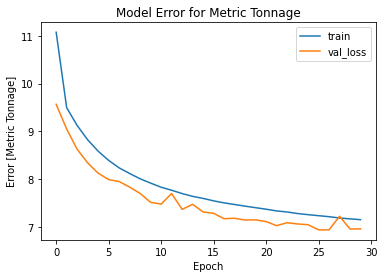

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train20_batch64_sc_30Epochs_HPO5batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

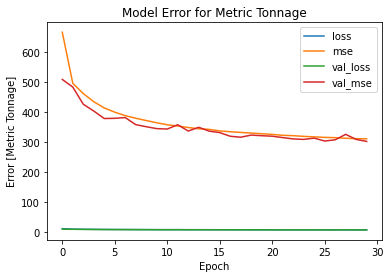

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train19_batch64_sc_30Epochs_HPO5batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

81633/81633 [==============================] - 96s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2612228, 1)

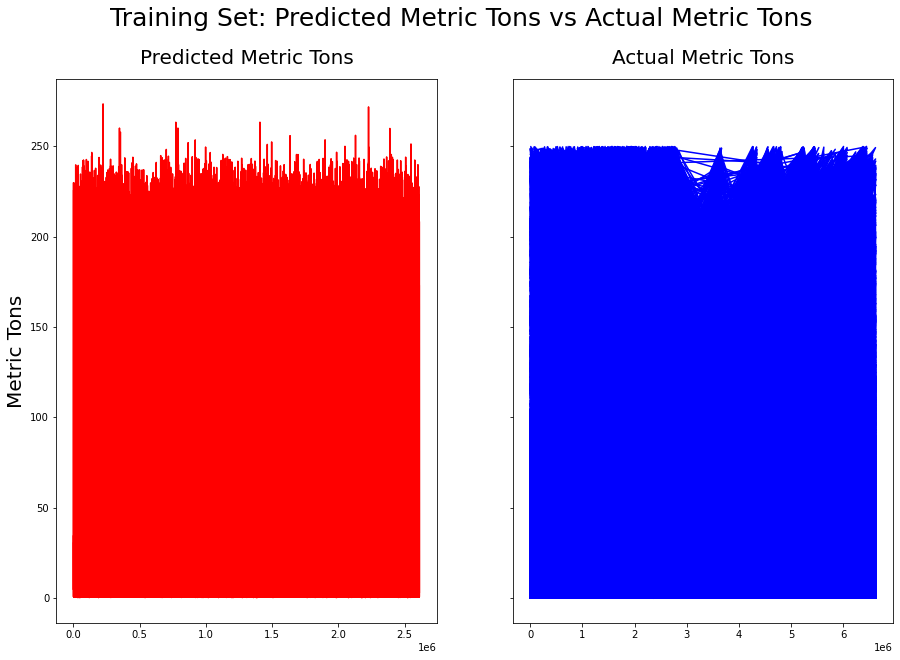

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

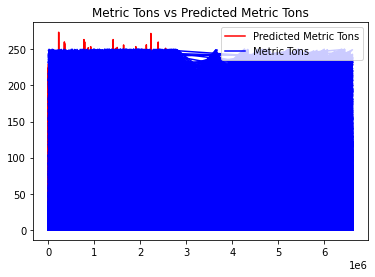

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

20409/20409 [==============================] - 24s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(653057, 1)

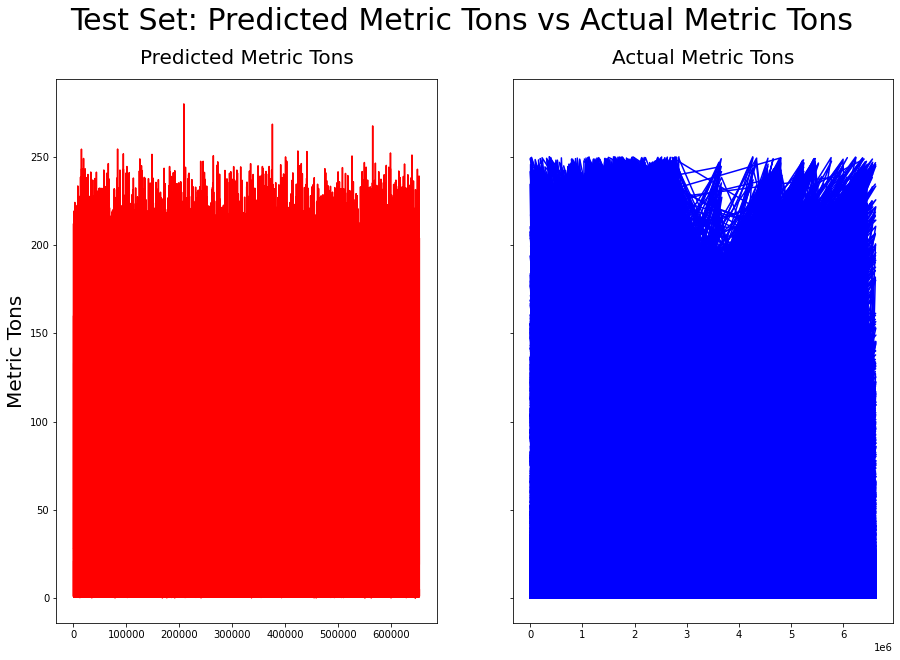

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

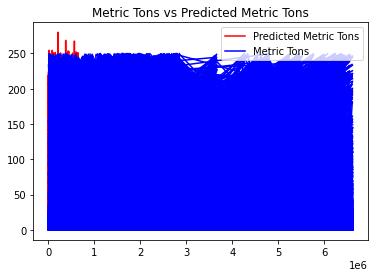

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.873764
MSE: 294.315735
RMSE: 17.155633
R2: 0.688206


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 7.960926
MSE: 364.528285
RMSE: 19.092624
R2: 0.613350


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 279.9192

Average Metric Tons: 21.5239324438755
Predicted Average Metric Tons: 21.063677

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: 0.038568497


#### Test on 2019

In [ ]:
# Prepare 2019 for partitioning data
X = df1.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df1['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

105266/105266 [==============================] - 126s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3368487, 1)

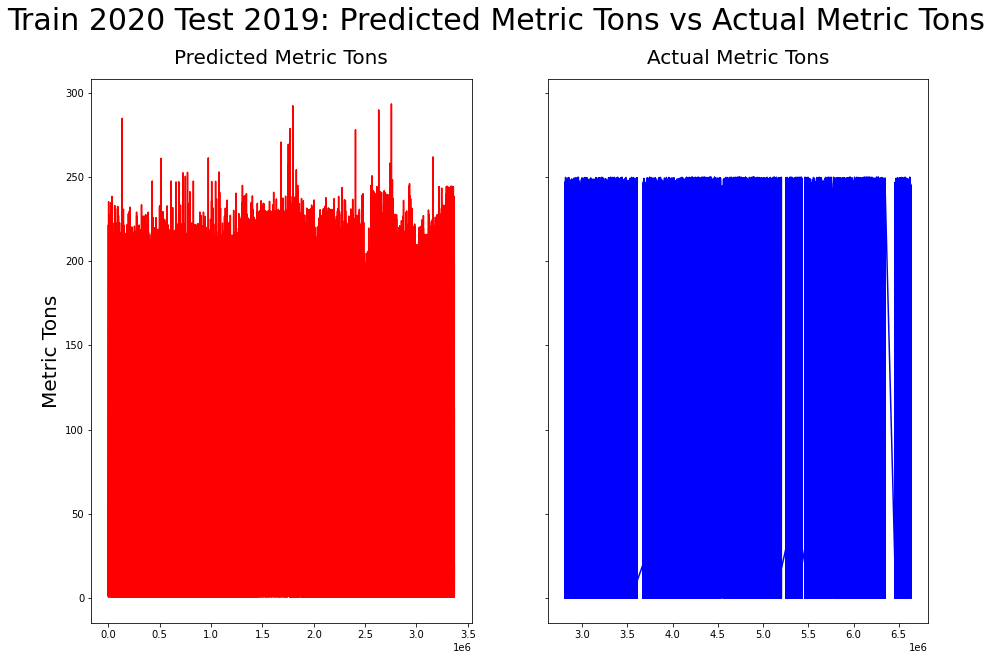

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2020 Test 2019: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20Test19_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

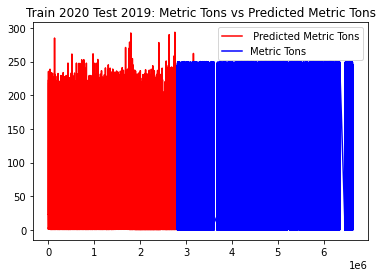

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2020 Test 2019: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20Test19_batch64_sc_30Epochs_HPO5batch16_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.233926
MSE: 486.813287
RMSE: 22.063846
R2: 0.516353


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 293.45172

Average Metric Tons: 21.897900731099753
Predicted Average Metric Tons: 19.431147

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: 0.69420147
